# Evaluation of GRN inference methods
## Explanatory analysis
### by Jalil Nourisa



# Imports

In [21]:
%reload_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import anndata as ad
import tqdm
import json
import warnings
import matplotlib
import sys
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import scanpy as sc 
import itertools
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.rcParams['font.family'] = 'Arial' # Arial or 'Liberation Sans'
default_font = matplotlib.rcParams['font.family']
print(default_font)


# - local imports (task_grn_inference should be along side this repo)
sys.path.append('../')
from src.helper import RESULT_DIR, surrogate_names, custom_jointplot, palette_celltype, \
                       palette_methods, DATASETS, \
                       palette_datasets, colors_blind, linestyle_methods, palette_datasets, CONTROLS3, linestyle_methods, retrieve_grn_path, TASK_GRN_INFERENCE_DIR

task_grn_inference_dir = TASK_GRN_INFERENCE_DIR
sys.path.append(task_grn_inference_dir)
from src.utils.util import naming_convention
# from src.utils.util import 
from src.exp_analysis.helper import Exp_analysis, create_interaction_info, jaccard_similarity_net


# - ordered names
from pandas.api.types import CategoricalDtype
category_order_reg1 = CategoricalDtype(categories=['GRNBoost2', 'Scenic+', 'Positive Ctrl', 'Pearson Corr.', 'GRaNIE'], ordered=True)
category_order_reg2 = CategoricalDtype(categories=['GRNBoost2', 'Positive Ctrl', 'Pearson Corr.', 'PPCOR'], ordered=True)


# - variables
perturb_col = 'perturbation'

# - directories
figs_dir = f'{RESULT_DIR}/figs'
os.makedirs(figs_dir, exist_ok=True)


# colors_methods = {name: colors_blind[i] for i, name in enumerate(['Baseline Correlation', 'Positive Control', 'GRaNIE', 'GRNBoost2', 'PPCOR', 'Scenic+'])} 

%matplotlib inline

python-dotenv could not parse statement starting at line 3
python-dotenv could not parse statement starting at line 3
python-dotenv could not parse statement starting at line 3
python-dotenv could not parse statement starting at line 3


['Arial']


# Analysis of pseudobulking

## bulk vs sc for large perturbation datasets

In [9]:
df_all = []
for dataset in ['replogle', 'xaira_HCT116', 'xaira_HEK293T']:
    df_d = pd.read_csv(f'{TASK_GRN_INFERENCE_DIR}/resources/results/experiment/bulk_vs_sc/metrics_{dataset}.csv')
    df_all.append(df_d)
df_all = pd.concat(df_all, ignore_index=True)


In [10]:
df_all.style.background_gradient()

,r2-theta-0.0,r2-theta-0.5,r2-theta-1.0,ws-theta-0.0,ws-theta-0.5,ws-theta-1.0,data_type,dataset
0,0.094243,0.064615,0.057407,0.669643,0.656417,0.649018,sc,replogle
1,0.088554,0.058681,0.051782,0.593535,0.571931,0.563528,bulk,replogle
2,0.074340,0.033270,0.024085,0.681232,0.710026,0.724417,sc,xaira_HCT116
3,0.060211,0.025537,0.018201,0.692810,0.654930,0.629651,bulk,xaira_HCT116
4,0.074047,0.029833,0.020285,0.714883,0.723448,0.728016,sc,xaira_HEK293T
5,0.062708,0.024892,0.016894,0.698610,0.667298,0.644996,bulk,xaira_HEK293T


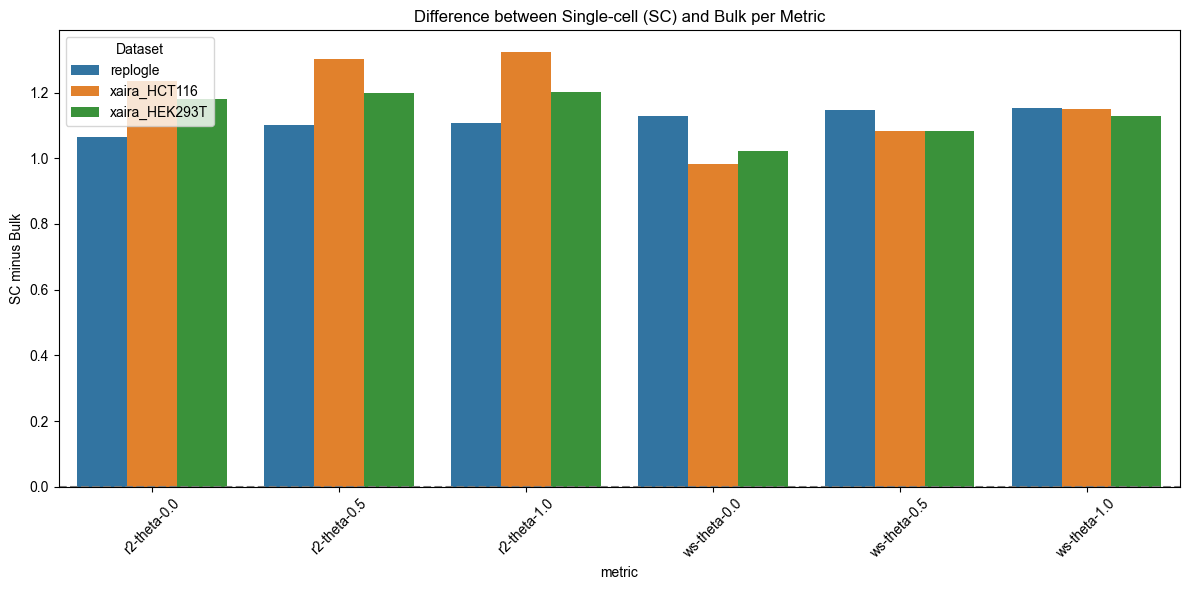

In [11]:
# melt for plotting
df = df_all.copy()

# Separate sc and bulk
sc = df[df['data_type'] == 'sc'].set_index('dataset')
bulk = df[df['data_type'] == 'bulk'].set_index('dataset')

# Compute difference (sc - bulk)
diff = sc[['r2-theta-0.0','r2-theta-0.5','r2-theta-1.0','ws-theta-0.0','ws-theta-0.5','ws-theta-1.0']] / \
       bulk[['r2-theta-0.0','r2-theta-0.5','r2-theta-1.0','ws-theta-0.0','ws-theta-0.5','ws-theta-1.0']]

diff = diff.reset_index().melt(id_vars='dataset', var_name='metric', value_name='sc_minus_bulk')

# Plot
plt.figure(figsize=(12,6))
sns.barplot(data=diff, x='metric', y='sc_minus_bulk', hue='dataset', ci=None)
plt.axhline(0, color='gray', linestyle='--')
plt.ylabel('SC minus Bulk')
plt.title('Difference between Single-cell (SC) and Bulk per Metric')
plt.xticks(rotation=45)
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

# Perturbation effects

### Gene wise evaluation

python-dotenv could not parse statement starting at line 3
python-dotenv could not parse statement starting at line 3
python-dotenv could not parse statement starting at line 3


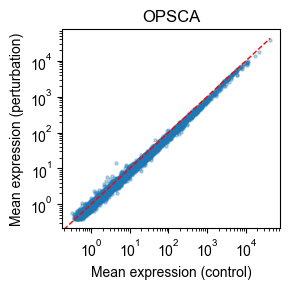

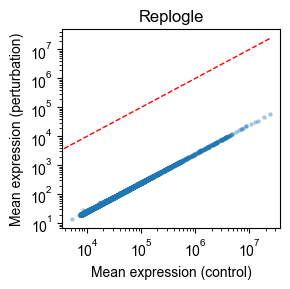

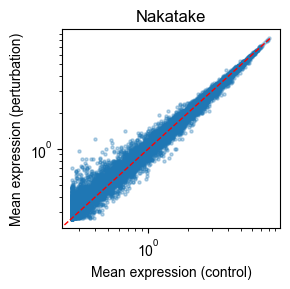

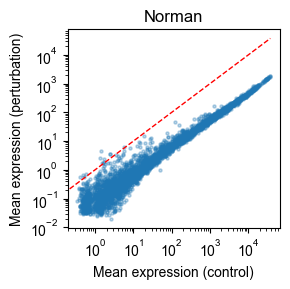

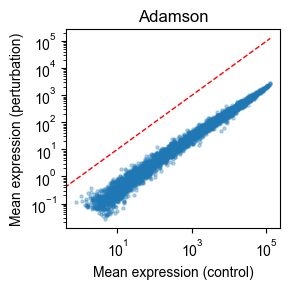

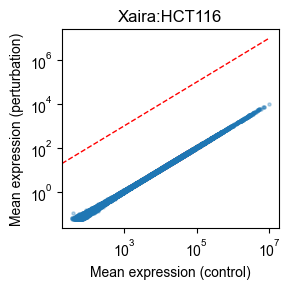

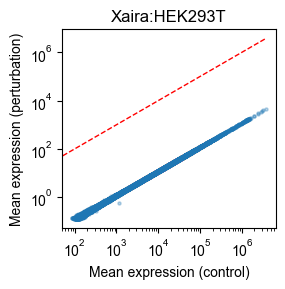

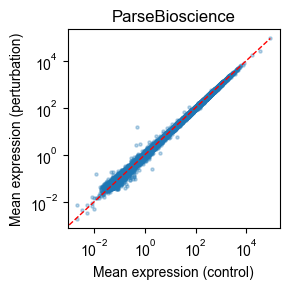

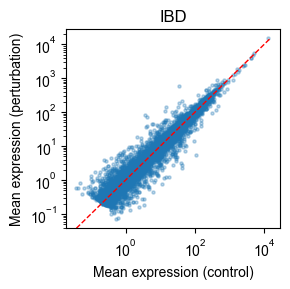

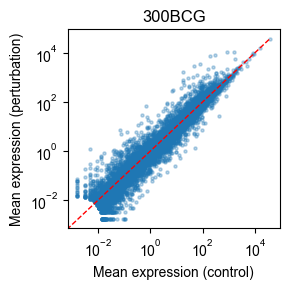

In [63]:
for i, dataset in enumerate(DATASETS):   
    adata = ad.read_h5ad(f'{task_grn_inference_dir}/resources/extended_data/{dataset}_bulk.h5ad')
    control_mask = adata.obs['is_control']
    non_control_mask = ~adata.obs['is_control']
    X = adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X
    mean_control = X[control_mask, :].mean(axis=0)
    mean_non_control = X[non_control_mask, :].mean(axis=0)
    plt.figure(figsize=(3, 3))
    plt.scatter(mean_control, mean_non_control, alpha=0.3, s=5)
    plt.plot([0, max(mean_control.max(), mean_non_control.max())],
            [0, max(mean_control.max(), mean_non_control.max())],
            color='red', linestyle='--', lw=1)
    plt.xlabel('Mean expression (control)')
    plt.ylabel('Mean expression (perturbation)')
    plt.title(f'{surrogate_names[dataset]}')
    plt.xscale('log')
    plt.yscale('log')
    plt.tight_layout()
    plt.show()

### Sample wise evaluation

In [36]:
from src.helper import determine_fold_change_effect
if True:
    perturbation_dict = {}
    for i, dataset in enumerate(DATASETS): 
        adata = ad.read_h5ad(f'{task_grn_inference_dir}/resources/extended_data/{dataset}_bulk.h5ad')
        print(dataset, ' number of perturbation: ', adata.obs['perturbation'].nunique())
        perturbation_dict[dataset] = adata
        perturb_effect_df = determine_fold_change_effect(adata)
        perturb_effect_df['Dataset'] = dataset
        if i == 0:
            perturb_effect_all = perturb_effect_df
        else:
            perturb_effect_all = pd.concat([perturb_effect_all, perturb_effect_df], axis=0)
    perturb_effect_all.to_csv(f'{RESULT_DIR}/perturb_effect_all.csv')
else:
    perturb_effect_all = pd.read_csv(f'{RESULT_DIR}/perturb_effect_all.csv', index_col=0)
perturb_effect_all.reset_index(drop=True, inplace=True)

op  number of perturbation:  138
replogle  number of perturbation:  7106
nakatake  number of perturbation:  463
norman  number of perturbation:  231
adamson  number of perturbation:  82
xaira_HCT116  number of perturbation:  11335
xaira_HEK293T  number of perturbation:  7222
parsebioscience  number of perturbation:  91
ibd  number of perturbation:  3
300BCG  number of perturbation:  2


['OPSCA' 'Replogle' 'Nakatake' 'Norman' 'Adamson' 'Xaira:HCT116'
 'Xaira:HEK293T' 'ParseBioscience' 'IBD' '300BCG']


(<Figure size 550x250 with 1 Axes>,
 <Axes: xlabel='Expression log2fc', ylabel='Dataset'>)

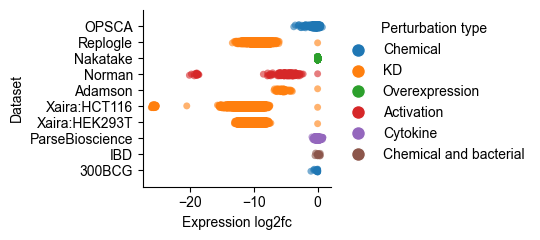

In [37]:
perturb_effect_all['Dataset'] = perturb_effect_all['Dataset'].map(lambda name: surrogate_names.get(name,name))
perturb_effect_all['Perturbation type'] = perturb_effect_all['Dataset'].map({
    'OPSCA': 'Chemical', 
    'Nakatake': 'Overexpression', 
    'Norman': 'Activation', 
    'Adamson': 'KD', 
    'Replogle': 'KD', 
    'Xaira:HCT116': 'KD', 
    'Xaira:HEK293T': 'KD', 
    'ParseBioscience': 'Cytokine',
    'IBD': "Chemical and bacterial",
    '300BCG': "Chemical"  
})
def wrapper_plot_fc(perturb_effect_df, title=None):
    import matplotlib.patches as mpatches
    import matplotlib.pyplot as plt
    import seaborn as sns
    fig, ax = plt.subplots(1, 1, figsize=(5.5, 2.5))
    print(perturb_effect_df['Dataset'].unique())
    sns.stripplot(
        data=perturb_effect_df,
        x="Expression fold change", 
        y="Dataset",
        hue="Perturbation type",
        dodge=False,
        jitter=True,
        alpha=0.6,
        size=5,  # increase point size
        ax=ax,
        palette="tab10"
    )
    ax.set_ylabel("Dataset")
    ax.set_xlabel("Expression log2fc")
    if title:
        ax.set_title(title, fontsize=10)
    perturb_types = perturb_effect_df['Perturbation type'].unique()
    palette = sns.color_palette("tab10", n_colors=len(perturb_types))
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w',
                                 markerfacecolor=palette[i], markersize=10,
                                 label=perturb_types[i]) for i in range(len(perturb_types))]
    ax.margins(y=0.1)
    ax.legend(handles=legend_handles, bbox_to_anchor=(1, 1), frameon=False, title="Perturbation type")
    for side in ["right", "top"]:
        ax.spines[side].set_visible(False)

    plt.tight_layout()
    return fig, ax
# wrapper_plot_fc(perturb_effect_all[perturb_effect_all['Dataset'].isin(['Norman', 'Adamson', 'Replogle', 'Xaira:HCT116', 'Xaira:HEK293T'])], title="")
# wrapper_plot_fc(perturb_effect_all[perturb_effect_all['Dataset'].isin(['300BCG', 'IBD', 'Nakatake', 'OPSCA', 'Parsebioscience'])], title="")
wrapper_plot_fc(perturb_effect_all)

### STD vs mean change

/vol/tmp/users/jnourisa/ipykernel_1419720/1000066050.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(perturb_effect_df, x='STD fold change', y='Expression fold change', hue='Dataset', s=10,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/vol/tmp/users/jnourisa/ipykernel_1419720/1000066050.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(perturb_effect_df, x='STD fold change', y='Expression fold change', hue='Dataset', s=10,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/vol/tmp/users/jnourisa/ipykernel_1419720/1000066050.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(perturb_effect_df, x='STD fold change', y='Exp

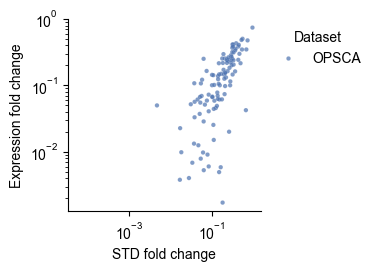

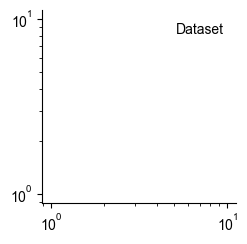

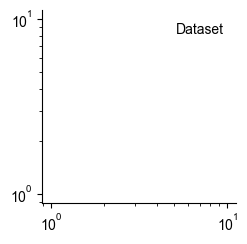

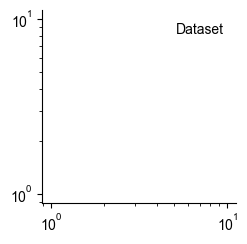

In [53]:
# - perturbation effect 
def wrapper_plot(perturb_effect_df):
    fig, ax = plt.subplots(1, 1, figsize=(2.5 , 2.5))
    def plot_perturbation_strength_datasets(perturb_effect_df, ax):
        sns.scatterplot(perturb_effect_df, x='STD fold change', y='Expression fold change', hue='Dataset', s=10,
                alpha=.7, ax=ax, linewidth=.1, edgecolor='white', palette={surrogate_names[name]: color for name, color in palette_datasets.items()})
        legend = ax.legend(bbox_to_anchor=(1, 1), frameon=False)
        legend.set_title("Dataset") 
        ax.set_yscale('log')
        ax.set_xscale('log')
        for side in ['right', 'top']:
            ax.spines[side].set_visible(False)
    plot_perturbation_strength_datasets(perturb_effect_df, ax)
    # fig.savefig(f"{RESULT_DIR}/figs/perturbation_strength_datasets.png", dpi=300, transparent=True, bbox_inches='tight')
wrapper_plot(perturb_effect_all[perturb_effect_all['Dataset'].isin(['OPSCA', 'ParseBioscience'])])

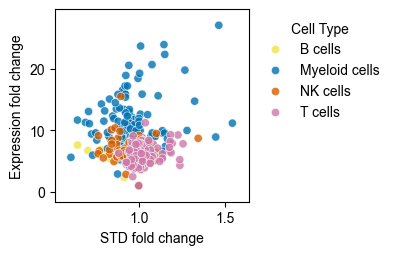

In [58]:
# - perturbation effect 
fig, ax = plt.subplots(1, 1, figsize=(2.5,2.5))
def plot_perturbation_strength_celltypes(perturb_effect_all, ax):
    sns.scatterplot(perturb_effect_all[perturb_effect_all['Dataset']=='OPSCA'], x='STD fold change', y='Expression fold change', hue='cell_type', alpha=.8, ax=ax, palette=colors_blind[3:])
    legend = ax.legend(bbox_to_anchor=(1, 1), frameon=False)
    legend.set_title("Cell Type") 
    ax.margins(x=0.1, y=0.1)
    # for side in ['right', 'top']:
    #     ax.spines[side].set_visible(False)
    # ax.set_title(f"Perturbation strength", pad=10, fontsize=12, fontweight='bold')
plot_perturbation_strength_celltypes(perturb_effect_all, ax)
fig.savefig(f"{RESULT_DIR}/figs/perturbation_strength_celltypes.png", dpi=300, transparent=True, bbox_inches='tight')

# Regression 2: consensus n regulators

In [2]:
thetas=['0', '0.5', '1']

In [3]:
def load_data(dataset, input_dir):
    """
    Load the JSON file for a given dataset and extract the data.
    """
    file_path = os.path.join(input_dir, 'resources/grn_benchmark/prior', f'regulators_consensus_{dataset}.json')
    with open(file_path, 'r') as f:
        data = json.load(f)
    gene_names = np.asarray(list(data.keys()), dtype=object)
    return data, gene_names

def process_features(data, gene_names, thetas):
    """
    Extract the number of features (regulators) for each theta value.
    """
    n_features = {
        theta: np.asarray([data[gene_name][theta] for gene_name in gene_names], dtype=int)
        for theta in thetas
    }
    return n_features

def plot_consensus_number_of_regulators(dataset, axes,thetas=['0', '0.5', '1'], color='#56B4E9'):
    """
    Create a plot for the consensus number of regulators for a dataset.
    """
    # Load and process data
    data, gene_names = load_data(dataset, task_grn_inference_dir)
    n_features = process_features(data, gene_names, thetas)
    
    
    for i, theta in enumerate(thetas):
        ax = axes[i]
        sns.histplot(
            data=n_features[theta], 
            ax=ax, 
            discrete=True, 
            color=color, 
            linewidth=.5, 
            edgecolor=None
        )
        ax.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='blue')
        for side in ['right', 'top']:
            ax.spines[side].set_visible(False)
        ax.set_yscale('log')
        ax.set_ylabel('Number of target genes')
        # ax.set_title(fr'$\theta$ = {theta}')
        if theta=='0':
            metric = "R2 (precision)"
        if theta=='0.5':
            metric = "R2 (balanced)"
        if theta=='1':
            metric = "R2 (recall)"
        ax.set_title(metric, pad=15, )
        ax.set_xlabel(r'Number of regulators')

    
    # output_path = os.path.join(output_dir, f"consensus_{dataset}.png")
    # fig.savefig(output_path, dpi=300, transparent=True, bbox_inches='tight')

def extract_nregulators_func(datasets, task_grn_inference_dir, results_folder, surrogate_names):
    """
    Analyze and plot the consensus number of regulators for a list of datasets.
    """
    n_genes_with_regulators_dict = {}

    for dataset in datasets:
        n_genes_with_regulators_dict[dataset] = []
        # Load and process data
        data, gene_names = load_data(dataset, task_grn_inference_dir)
        n_features = process_features(data, gene_names, thetas)

        # Calculate number of genes with at least one regulator for each theta
        for theta in thetas:
            n_genes_with_regulators_dict[dataset].append((n_features[theta] != 0).sum())
    return n_genes_with_regulators_dict

In [5]:
# - format it and store in one df
df_store = []
for dataset in DATASETS:
    data, gene_names = load_data(dataset, task_grn_inference_dir)
    n_features = process_features(data, gene_names, thetas)
    df = pd.DataFrame(n_features).melt(var_name='theta')
    df['dataset'] = dataset
    df_store.append(df)
regulatorys_consensus = pd.concat(df_store)
regulatorys_consensus['dataset'] = regulatorys_consensus['dataset'].map(surrogate_names)
regulatorys_consensus['theta'] = regulatorys_consensus['theta'].map({'0':"R2 (precision)", '0.5':"R2 (balanced)", '1':"R2 (recall)"})
regulatorys_consensus['theta'].unique()

array(['R2 (precision)', 'R2 (balanced)', 'R2 (recall)'], dtype=object)

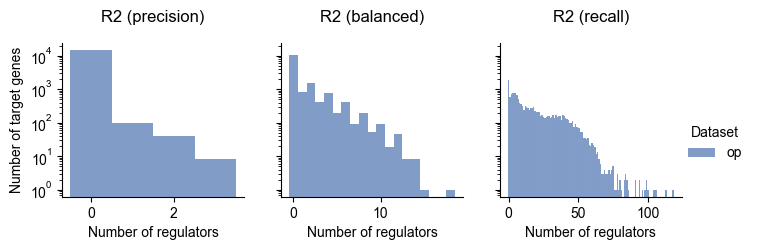

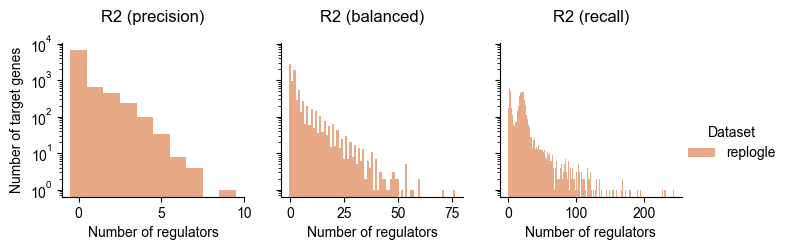

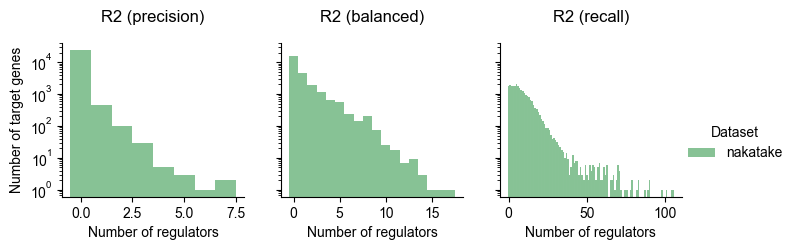

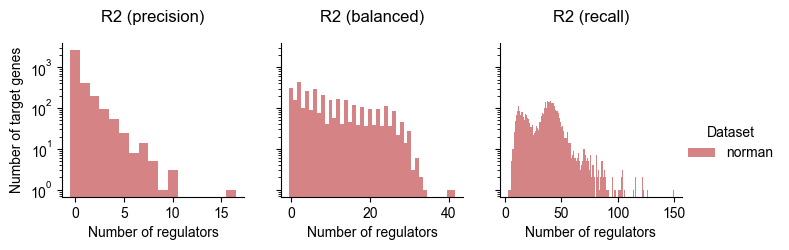

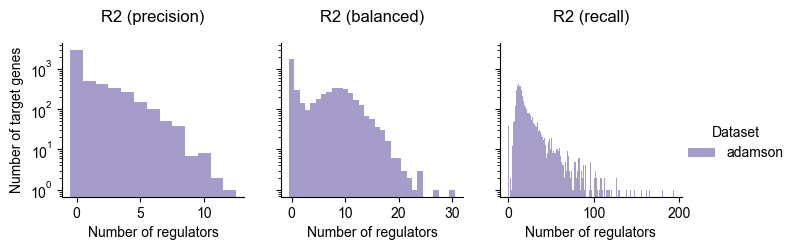

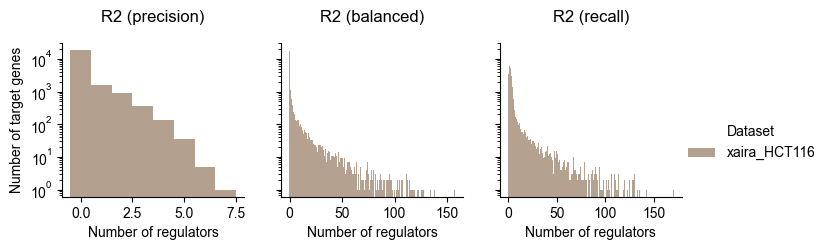

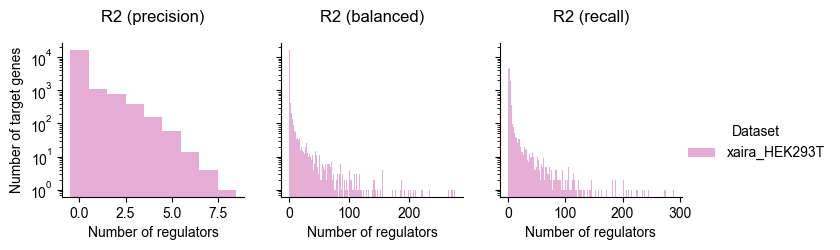

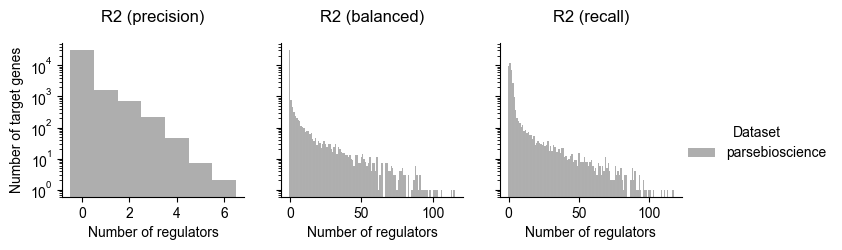

In [15]:

for dataset in DATASETS:
    fig, axes = plt.subplots(1, 3, figsize=(8, 2), sharey=True)
    color=palette_datasets[dataset]
    

    # Load and process data
    data, gene_names = load_data(dataset, task_grn_inference_dir)
    n_features = process_features(data, gene_names, thetas)
    
    
    for i, theta in enumerate(thetas):
        ax = axes[i]
        sns.histplot(
            alpha=.7,
            # edgecolor='black',
            data=n_features[theta], 
            ax=ax, 
            discrete=True, 
            color=color, 
            linewidth=.01, 
            edgecolor='white',
            label=dataset
        )
        # ax.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='blue')
        for side in ['right', 'top']:
            ax.spines[side].set_visible(False)
        ax.set_yscale('log')
        ax.set_ylabel('Number of target genes')
        # ax.set_title(fr'$\theta$ = {theta}')
        if theta=='0':
            metric = "R2 (precision)"
        if theta=='0.5':
            metric = "R2 (balanced)"
        if theta=='1':
            metric = "R2 (recall)"
        ax.set_title(metric, pad=15, )
        ax.set_xlabel(r'Number of regulators')
    # plt.savefig(f"{RESULT_DIR}/figs/nregulators_opsca.png", dpi=300, transparent=True, bbox_inches='tight')
    # plt.show()
    plt.legend(loc=(1,.2), frameon=False, title='Dataset')
# fig.savefig(f"{RESULT_DIR}/figs/consensus_regulators.png", dpi=300, transparent=True, bbox_inches='tight')



In [6]:
n_genes_with_regulators_dict = extract_nregulators_func(
    datasets=DATASETS,
    task_grn_inference_dir=task_grn_inference_dir,
    results_folder=results_folder,
    surrogate_names=surrogate_names
)

/vol/tmp/users/jnourisa/ipykernel_2573630/2267351554.py:11: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.barplot(df, x='dataset', y='value', hue='index', palette=colors_blind[2:])


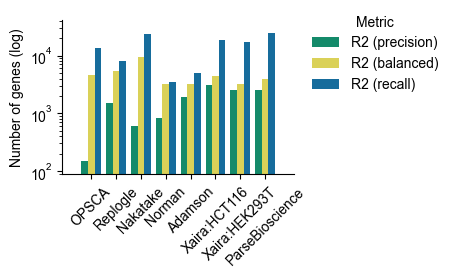

In [7]:
# Number of genes with actual regulators 
fig, ax = plt.subplots(1,1, figsize=(3, 2), sharey=True)
def plot_n_genes_with_regulators(n_genes_with_regulators_dict, ax):
    df = pd.DataFrame(n_genes_with_regulators_dict)
    df.index = ['r2-theta-0.0', 'r2-theta-0.5', 'r2-theta-1.0']
    df.index = df.index.map(surrogate_names)
    df.columns = df.columns.map(surrogate_names)

    df = df.reset_index().melt(id_vars = 'index', var_name='dataset')
    df.index.name = 'Metric'
    sns.barplot(df, x='dataset', y='value', hue='index', palette=colors_blind[2:])
    # ax.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='blue')
    # for side in ['right', 'top']:
    #     ax.spines[side].set_visible(False)
    ax.margins(x=.1)
    ax.margins(y=.1)
    ax.set_yscale('log')
    # ax.set_xlabel(r'Number of selected regulators')
    ax.set_ylabel('Number of genes (log)')
    ax.set_xlabel(r'')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # plt.title('Consensus genes with regulators', fontsize=12, fontweight='bold', pad=15)
    plt.legend(loc=(1.05, .5),frameon=False, title='Metric')
    plt.xticks(rotation=45)
plot_n_genes_with_regulators(n_genes_with_regulators_dict, ax)
fig.savefig(f"{RESULT_DIR}/figs/consensus_all.png", dpi=300, transparent=True, bbox_inches='tight')


# WS distance: consensus plot

In [8]:
consensus_store = []
for dataset in ['adamson', 'norman', 'replogle', 'xaira_HCT116', 'xaira_HEK293T']:
    consensus = pd.read_csv(f'{task_grn_inference_dir}/resources/grn_benchmark/prior/ws_consensus_{dataset}.csv', index_col=0)
    consensus['dataset'] = dataset
    consensus_store.append(consensus)
consensus = pd.concat(consensus_store)
consensus['theta'] = consensus['theta'].map(surrogate_names)
consensus.groupby(['dataset'])['source'].nunique()

consensus['dataset'] = consensus['dataset'].map(surrogate_names)

In [9]:
print(consensus.groupby(['dataset'])['source'].nunique())


dataset
Adamson            7
Norman            23
Replogle         491
Xaira:HCT116     476
Xaira:HEK293T    399
Name: source, dtype: int64


/vol/tmp/users/jnourisa/ipykernel_2573630/1751700805.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


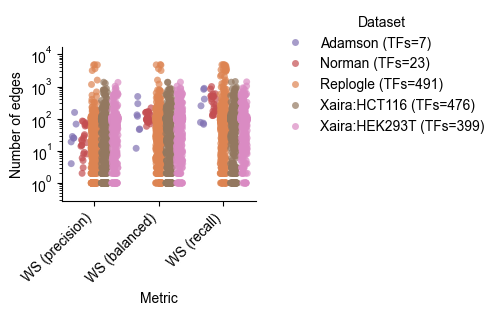

In [10]:

# Count the number of points per dataset
dataset_counts = consensus.groupby(['dataset'])['source'].nunique()

# Create legend labels with dataset names and counts
legend_labels = {name: f"{name} (TFs={count})" for name, count in dataset_counts.items()}

fig, ax = plt.subplots(1, 1, figsize=(2.5, 2))

sns.stripplot(
    data=consensus, x='theta', y='value', hue='dataset', ax=ax, alpha=.7, 
    edgecolor='black', dodge=True, jitter=0.25,  
    palette={surrogate_names[name]: color for name, color in palette_datasets.items()}
)

plt.yscale('log')  
plt.xlabel('Metric')  
plt.ylabel('Number of edges') 
plt.margins(y=.15) 

# Modify the legend to include counts
handles, labels = ax.get_legend_handles_labels()
new_labels = [legend_labels[label] for label in labels]
ax.legend(handles, new_labels, loc=(1.1, .4), frameon=False, title='Dataset')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

fig.savefig(f"{RESULT_DIR}/figs/consensus_ws.png", dpi=300, transparent=True, bbox_inches='tight')

# Stability analysis: Regression 1

In [10]:
dataset = 'op' 


par_reg1 = {
    'grn_models': ['pearson_corr', 'granie', 'grnboost', 'scenicplus'],
    'enrichment_models': ['pearson_corr', 'grnboost', 'scenicplus'],
    'grn_models_dir': f'{task_grn_inference_dir}/resources/grn_models/{dataset}/',
    'evaluation_data': f'{task_grn_inference_dir}/resources/grn_benchmark/evaluation_data/{dataset}_bulk.h5ad',
    'layer': 'X_norm',
    'consensus':  f'../output/{dataset}_consensus-num-regulators.json',
    'tf_all': f'{task_grn_inference_dir}/resources/grn_benchmark/prior/tf_all.csv',
    'static_only': False,
    'num_workers': 4,
    'apply_tf': True,
    'apply_skeleton': False,
    'verbose': 2,
    'max_n_links': 50_000,
}

exp_objs_dict = {}

for model in par_reg1['grn_models']:
    par_reg1['grn_model'] = f"{par_reg1['grn_models_dir']}/{model}.csv"
    if not os.path.exists(par_reg1['grn_model']):
        print(model, ' is skipped')
        continue
    net = pd.read_csv(par_reg1['grn_model'])

    print(model, len(net))
    obj = Exp_analysis(net)
    obj.calculate_basic_stats()
    exp_objs_dict[model] = obj


interaction_info = create_interaction_info(exp_objs_dict)

pearson_corr 50000
granie 50000
grnboost  is skipped
scenicplus 41288


### Run the analysis

In [11]:
# - read inputs
tf_all = np.loadtxt(f'{task_grn_inference_dir}/resources/grn_benchmark/prior/tf_all.csv', dtype=str)

perturb_data = ad.read_h5ad(par_reg1['evaluation_data'])
if par_reg1['layer'] == 'X':
    pass
else:
    perturb_data.X = perturb_data.layers[par_reg1['layer']]
gene_names = perturb_data.var_names

KeyError: 'X_norm'

In [38]:
# - calculate the scores and feature importance 
if False:
    # - imports 
    sys.path.append(f'{task_grn_inference_dir}')

    from src.metrics.regression_1.helper import cross_validation, process_net
    scores_store = []

    if 'donor_id' not in perturb_data.obs:
        perturb_data.obs['donor_id'] = 'donor_one'
        perturb_data.obs['cell_type'] = 'cell_type'

    i_iter = 0
    for reg_type in ['ridge']:
        for donor_id in perturb_data.obs.donor_id.unique():
            perturb_data_sub = perturb_data[perturb_data.obs.donor_id == donor_id]
            obs = perturb_data_sub.obs.reset_index(drop=True)

            for i_model, model in enumerate(par_reg1['grn_models']):
                net = ad.read_h5ad(f"{par_reg1['grn_models_dir']}/{model}.h5ad").uns['prediction']
                
                
                results = cross_validation(net, perturb_data_sub, par={'reg_type':reg_type, 'verbose':3, 'num_workers':2})
                reg_models = results['reg_models']
                r2score_samples = results['r2scores']                

                if reg_type == 'ridge':
                    coeffs = [reg.coef_ for reg in reg_models]
                else:
                    coeffs = [reg.get_feature_importance() for reg in reg_models]

                # - mean of feature importance across CVs
                net_mat = process_net(net.copy(), gene_names)
                mean_coeff = pd.DataFrame(
                    np.mean(coeffs, axis=0),
                    columns=net_mat.columns,
                    index=pd.MultiIndex.from_frame(obs[[perturb_col, 'cell_type']])
                )    
                # - normalize feature importance for each sample
                mean_coeff = mean_coeff.abs()
                mean_coeff = mean_coeff.div(mean_coeff.max(axis=1), axis=0)
                
                # - long df for feature importance 
                mean_coeff  = mean_coeff.reset_index()
                mean_coeff = mean_coeff.melt(id_vars=[perturb_col, 'cell_type'], var_name='tf', value_name='feature_importance')
                mean_coeff['model'] = model
                mean_coeff['donor_id'] = donor_id

                if i_iter == 0:
                    feature_importance_all = mean_coeff
                else:
                    feature_importance_all = pd.concat([feature_importance_all, mean_coeff], axis=0)

                for i_sample, score_sample in enumerate(r2score_samples):
                    scores_store.append({
                        'reg_type': reg_type,
                        'donor_id':donor_id,
                        'r2score':score_sample,
                        'model': model,
                        'cell_type': obs.loc[i_sample]['cell_type'],
                        perturb_col: obs.loc[i_sample][perturb_col]
                    })
                i_iter+=1
                
    scores_store = pd.DataFrame(scores_store)
    scores_store.to_csv(f'{RESULT_DIR}/stability_analysis/op/scores_store.csv')
    feature_importance_all.to_csv(f'{RESULT_DIR}/stability_analysis/op/feature_importance.csv')

### retrieve the results

In [39]:
results_folder

'../../task_grn_inference/resources/results/'

In [40]:
# - retireive data and subset to one reg type
reg_type = 'ridge'

scores_store_all_reg1= pd.read_csv(f'{RESULT_DIR}/stability_analysis/op/scores_store.csv', index_col=0)
feature_importance_all_reg1 = pd.read_csv(f'{RESULT_DIR}/stability_analysis/op/feature_importance.csv', index_col=0)


scores_store_all_reg1.rename(columns={'sm_name':'perturbation'}, inplace=True)
feature_importance_all_reg1.rename(columns={'sm_name':'perturbation'}, inplace=True)


scores_store_all_reg1.model = scores_store_all_reg1.model.map(surrogate_names)
feature_importance_all_reg1.model = feature_importance_all_reg1.model.map(surrogate_names)

scores_store_all_reg1['donor_id'] = scores_store_all_reg1['donor_id'].map({'donor_0':'Donor 1', 'donor_1':'Donor 2', 'donor_2':'Donor 3'})
feature_importance_all_reg1['donor_id'] = feature_importance_all_reg1['donor_id'].map({'donor_0':'Donor 1', 'donor_1':'Donor 2', 'donor_2':'Donor 3'})

In [41]:
feature_importance_all_reg1['model'] = feature_importance_all_reg1['model'].astype('category')

In [42]:
def plot_sample_wise_scores_distribution(scores_store_all_reg1, ax):
    # Get unique models and define colors
    models = scores_store_all_reg1['model'].unique()
      # Use a colormap for unique colors

    # Plot histograms for each model
    for model in models:
        
        subset = scores_store_all_reg1[scores_store_all_reg1['model'] == model]
        ax.hist(subset['r2score'], bins=50, alpha=0.5, label=model, color=palette_methods[model], edgecolor=None)

    # Add legend and labels
    ax.set_xlabel("R² Score")
    ax.set_ylabel("Number of samples")
    ax.legend(loc=(1.06, .2), title="Model", frameon=False)

    # for side in ['right', 'top']:
    #     ax.spines[side].set_visible(False)

    # plt.title('Sample-wise performance (OPSCA)', fontsize=12, fontweight='bold', pad=15)
# fig, ax = plt.subplots(figsize=(2.5, 2))

# plot_sample_wise_scores_distribution(scores_store_all_reg1, ax)
# plt.tight_layout()

# fig.savefig(f"{RESULT_DIR}/figs/reg1_sample_wise_scores_dist.png", dpi=300, transparent=True, bbox_inches='tight')

# plt.show()

### Consistency across donors

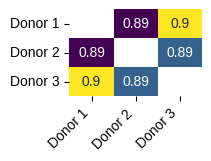

In [43]:
def plot_sample_wise_scores_similarity_donors(scores_store_all_reg1, ax):
    scores_store_table = scores_store_all_reg1.pivot_table(
        index='donor_id', 
        values='r2score', 
        columns=[col for col in scores_store_all_reg1.columns if col not in ['donor_id', 'r2score']]
    ).fillna(0)

    # Calculate the Spearman correlation matrix
    corr_matrix = scores_store_table.T.corr(method='spearman')

    np.fill_diagonal(corr_matrix.values, np.nan)
    # Plot heatmap on the appropriate subplot axis
    sns.heatmap(corr_matrix, annot=True, cmap="viridis", cbar=False, ax=ax)

    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis='y', rotation=0)
    ax.tick_params(axis='x', rotation=45)
    for label in ax.get_xticklabels():
        label.set_ha('right')  # Set horizontal alignment to 'left'



    # plt.title('Performance correlation (OPSCA)', fontsize=12, fontweight='bold', pad=15)
fig, ax = plt.subplots(1, 1, figsize=(2, 1.5), constrained_layout=True)

plot_sample_wise_scores_similarity_donors(scores_store_all_reg1, ax)
# plt.tight_layout()

# fig.savefig(f"{RESULT_DIR}/figs/reg1_sample_wise_donor_corr.png", dpi=300, transparent=True, bbox_inches='tight')


### Similarity in performance across models

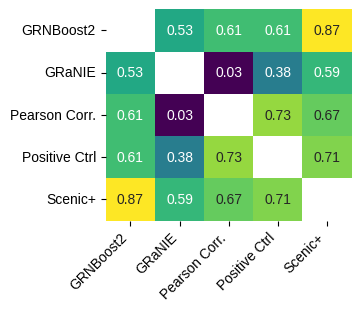

In [44]:
def plot_sample_wise_scores_similarity_models(scores_store_all_reg1, ax):
    scores_store_table = scores_store_all_reg1.pivot_table(
        index='model', 
        values='r2score', 
        columns=[col for col in scores_store_all_reg1.columns if col not in ['model', 'r2score']]
    ).fillna(0)

    spearman_corr = scores_store_table.T.corr(method='spearman')
    np.fill_diagonal(spearman_corr.values, np.nan)
    sns.heatmap(spearman_corr, annot=True, cmap="viridis", cbar=False, ax=ax, fmt='.2f')

    ax.set_xlabel("")
    ax.set_ylabel("")

    ax.tick_params(axis='x', rotation=45)
    for label in ax.get_xticklabels():
        label.set_ha('right')  # Set horizontal alignment to 'left'

    # plt.title('Performance correlation (OPSCA)', fontsize=12, fontweight='bold', pad=15)
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3), constrained_layout=True)

plot_sample_wise_scores_similarity_models(scores_store_all_reg1, ax)
# plt.tight_layout()

fig.savefig(f"{RESULT_DIR}/figs/reg1_sample_wise_model_corr.png", dpi=300, transparent=True, bbox_inches='tight')


### Performance segregated by cell types


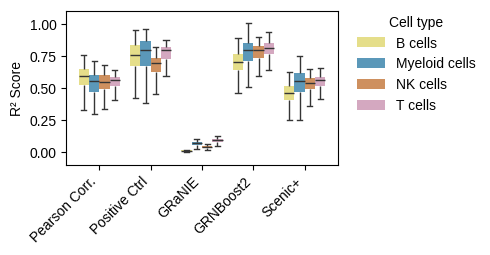

In [45]:

def plot_sample_wise_scores_segregated_by_celltypes(scores_store_all_reg1, ax):

    sns.boxplot(data=scores_store_all_reg1, x="model", y="r2score", hue="cell_type", ax=ax, showfliers=False, palette=colors_blind[3:], boxprops={'edgecolor': 'none', 'alpha':.7} )

    ax.set_ylabel("R² Score")
    ax.set_xlabel("")
    ax.legend(loc=(1.05, .3), title="Cell type", frameon=False)

    # for side in ['right', 'top']:
    #     ax.spines[side].set_visible(False)
    for label in ax.get_xticklabels():
        label.set_ha('right')  # Set horizontal alignment to 'left'
    ax.margins(x=.05, y=.1)
    # plt.title('Performance across cell types (OPSCA)', fontsize=12, fontweight='bold', pad=15)
    ax.tick_params(axis='x', rotation=45)
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
plot_sample_wise_scores_segregated_by_celltypes(scores_store_all_reg1, ax)
# plt.tight_layout()

# fig.savefig(f"{RESULT_DIR}/figs/reg1_sample_wise_cell_type.png", dpi=300, transparent=True, bbox_inches='tight')

plt.show()

### Performacne segragated by PC and NC samples

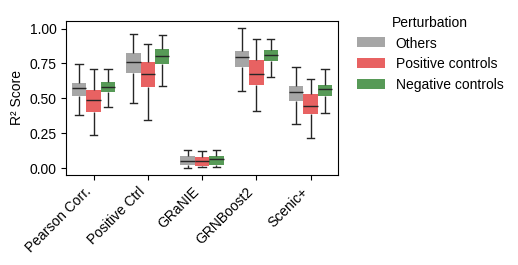

In [46]:
def plot_sample_wise_scores_segregated_by_controls(scores_store_all_reg1, ax):
    scores_store_all_reg1['controls'] = 'Others'
    mask_pc = scores_store_all_reg1.perturbation.isin(['Dabrafenib', 'Belinostat'])
    scores_store_all_reg1.loc[mask_pc, 'controls'] = 'Positive controls'
    mask_nc = scores_store_all_reg1.perturbation.isin(['Dimethyl Sulfoxide'])
    scores_store_all_reg1.loc[mask_nc, 'controls'] = 'Negative controls'

    scores_store_controls = scores_store_all_reg1[scores_store_all_reg1.perturbation.isin(CONTROLS3)]

    # - plot for all cell types

    sns.boxplot(data=scores_store_all_reg1, x="model", y="r2score", hue="controls", ax=ax,  palette=['grey']+['red','green'], boxprops={'edgecolor': 'none', 'alpha':.7}, showfliers=False)

    ax.set_ylabel("R² Score")
    ax.set_xlabel("")
    ax.legend(loc=(1.05, .5), title="Perturbation", frameon=False)
    
    # for side in ['right', 'top']:
    #     ax.spines[side].set_visible(False)
    for label in ax.get_xticklabels():
        label.set_ha('right')  # Set horizontal alignment to 'left'

    # plt.title('Performance across compounds (OPSCA)', fontsize=12, fontweight='bold', pad=15)
    ax.tick_params(axis='x', rotation=45)
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

plot_sample_wise_scores_segregated_by_controls(scores_store_all_reg1, ax)
# plt.tight_layout()

# fig.savefig(f"{RESULT_DIR}/figs/reg1_sample_wise_compounds.png", dpi=300, transparent=True, bbox_inches='tight')

plt.show()


### Joint distribution of sample wise scores

In [47]:
scores_store_all_reg1['model'].unique()

array(['Pearson Corr.', 'Positive Ctrl', 'GRaNIE', 'GRNBoost2', 'Scenic+'],
      dtype=object)

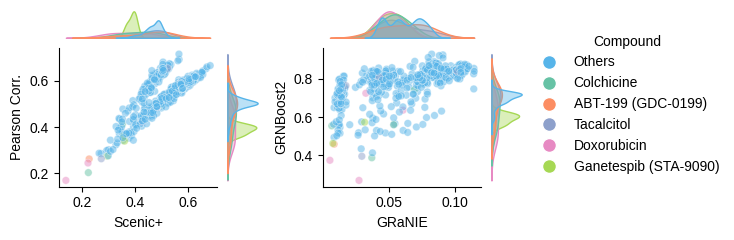

In [48]:
def determine_low_scoring_compounds(scores_store_all_reg1, x_name, y_name):
    if dataset == 'op':
        # Aggregate the data to handle duplicates
        subset_df_agg = scores_store_all_reg1.groupby(['perturbation', 'cell_type', 'model'], as_index=False)['r2score'].mean()
        pivot_df = subset_df_agg.pivot(index=['perturbation', 'cell_type'], columns='model', values='r2score')
    else:
        subset_df_agg = scores_store_all_reg1.groupby([perturb_col, 'model'], as_index=False)['r2score'].mean()
        pivot_df = subset_df_agg.pivot(index=[perturb_col], columns='model', values='r2score')
        pass
    pivot_df = pivot_df.reset_index()
    
    low_score_compounds = pivot_df[[perturb_col, x_name, y_name]].sort_values(by=[x_name, y_name]).head(8)
    low_score_mask = pivot_df[perturb_col].isin(low_score_compounds[perturb_col])
    low_scoring_samples = pivot_df[low_score_mask][perturb_col].unique()
    return low_scoring_samples

def plot_joint_sample_wise_scores(scores_store_all_reg1, x_name, y_name, ax):
    if dataset == 'op':
        # Aggregate the data to handle duplicates
        subset_df_agg = scores_store_all_reg1.groupby(['perturbation', 'cell_type', 'model'], as_index=False)['r2score'].mean()
        pivot_df = subset_df_agg.pivot(index=['perturbation', 'cell_type'], columns='model', values='r2score')
    else:
        subset_df_agg = scores_store_all_reg1.groupby([perturb_col, 'model'], as_index=False)['r2score'].mean()
        pivot_df = subset_df_agg.pivot(index=[perturb_col], columns='model', values='r2score')
        pass
    pivot_df = pivot_df.reset_index()
    
    low_score_mask = pivot_df[perturb_col].isin(common_low_scoring_samples)
    
    low_scoring_samples = pivot_df[low_score_mask][perturb_col].unique()

    pivot_df['perturb_filter'] = 'Others'
    
    pivot_df.loc[low_score_mask, 'perturb_filter'] = pivot_df.loc[low_score_mask, perturb_col]

    custom_jointplot(pivot_df, x = f"{x_name}",
        y = f"{y_name}", 
        hue='perturb_filter', ax=ax, scatter_kws={'s':30, 'palette':color_map})

    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    ax.legend(loc=(1.2, 0), title="Perturbation", frameon=False)
    return low_scoring_samples
low_scoring_samples_store = []
for i in range(3):
    for j in range(3):
        if i == j:
            continue

        name1 = surrogate_names[par_reg1['grn_models'][i]]
        name2 = surrogate_names[par_reg1['grn_models'][j]]
        

        low_scoring_samples = determine_low_scoring_compounds(scores_store_all_reg1, name1, name2)

        if (name1.lower()=='granie') | (name2.lower()=='granie'):
            pass
        else:
            low_scoring_samples_store.append(low_scoring_samples)
        # plt.suptitle('Performance across compounds (OPSCA)', fontsize=12, fontweight='bold', y=1.2)
common_low_scoring_samples = set.intersection(*map(set, low_scoring_samples_store))
color_map = {'Others': colors_blind[1]}
palette = sns.color_palette("Set2", n_colors=len(common_low_scoring_samples))
color_map.update({sample: palette[i] for i, sample in enumerate(common_low_scoring_samples)})


fig, axes = plt.subplots(1, 2, figsize=(7.5, 2.5))

ax = axes[0]
plot_joint_sample_wise_scores(scores_store_all_reg1, x_name='Scenic+', y_name='Pearson Corr.', ax=ax)
ax.get_legend().remove()
ax = axes[1]
plot_joint_sample_wise_scores(scores_store_all_reg1, x_name='GRaNIE', y_name='GRNBoost2', ax=ax)
ax.get_legend().remove()

legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[name], markersize=10, label=name)
        for name in color_map.keys()
    ]

ax.legend(handles=legend_elements, loc=(1.3, 0.05), frameon=False, title='Compound')

plt.tight_layout()
plt.savefig(f"{RESULT_DIR}/figs/reg1_sample_wise_compound.png", dpi=300, transparent=True, bbox_inches='tight')

plt.show()


In [49]:
low_scoring_samples_intersect = np.intersect1d(low_scoring_samples_store[0], low_scoring_samples_store[1])
low_scoring_samples_intersect

array(['ABT-199 (GDC-0199)', 'Colchicine', 'Doxorubicin',
       'Ganetespib (STA-9090)', 'Tacalcitol'], dtype=object)

/vol/tmp/users/jnourisa/ipykernel_3245699/3636174929.py:15: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  sns.scatterplot(perturb_effect_all, x='STD fold change', y='Expression fold change', hue='perturbation_subset', alpha=.8, ax=ax, palette=sns.color_palette('Set2'))


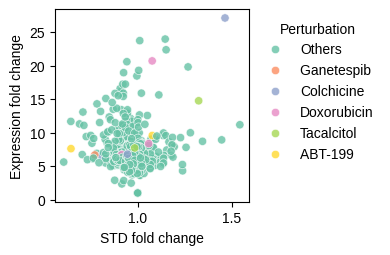

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5))

def plot_perturbation_strength_lowscored_samples(feature_importance_all_reg1, ax):

    low_scoring_samples = np.concatenate(low_scoring_samples_store)
    perturb_effect_all = pd.read_csv(f'{RESULT_DIR}/perturb_effect_all.csv')
    perturb_effect_all = perturb_effect_all[perturb_effect_all['Dataset']=='op']
    low_score_mask = perturb_effect_all['perturbation'].isin(low_scoring_samples_intersect)

    perturb_effect_all['perturbation_subset'] = 'Others'
    perturb_effect_all.loc[low_score_mask, 'perturbation_subset'] = perturb_effect_all.loc[low_score_mask, 'perturbation']

    perturb_effect_all['perturbation_subset'] = perturb_effect_all['perturbation_subset'].str.split('(', expand=True)[0]

    sns.scatterplot(perturb_effect_all, x='STD fold change', y='Expression fold change', hue='perturbation_subset', alpha=.8, ax=ax, palette=sns.color_palette('Set2')) 
    # for side in ['right', 'top']:
    #     ax.spines[side].set_visible(False)
    ax.legend(bbox_to_anchor=(1, 1), frameon=False, title="Perturbation")
    # ax.set_title(f"Perturbation strength", pad=10, fontsize=12, fontweight='bold')
plot_perturbation_strength_lowscored_samples(feature_importance_all_reg1, ax)

# fig.savefig(f"{RESULT_DIR}/figs/perturbation_strength_lowscored_compounds.png", dpi=300, transparent=True, bbox_inches='tight')

### Feature importance: similarity across models

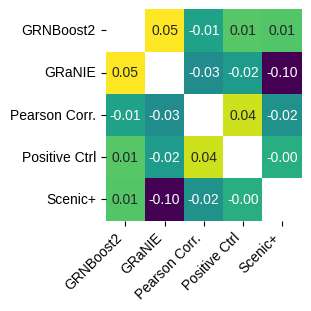

In [51]:

def plot_feature_importance_correlation_variation_across_models(feature_importance_all_reg1, ax):

    # - model specific feature importance -> only intersections 
    def lambda_func(df):
        return df['feature_importance'].values.flatten()

    df_pivot = feature_importance_all_reg1.groupby('model').apply(lambda_func)
    df_pivot = pd.DataFrame(df_pivot.tolist(), index=df_pivot.index)

    spearman_corr = df_pivot.T.corr(method='spearman')

    np.fill_diagonal(spearman_corr.values, np.nan)
    sns.heatmap(spearman_corr, annot=True, cmap="viridis", cbar=False, ax=ax, fmt=".2f")

    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=0)
    for label in ax.get_xticklabels():
        label.set_ha('right')  # Set horizontal alignment to 'left'

    # plt.title('TF activation similarity (OPSCA)', fontsize=12, fontweight='bold', pad=15)
fig, ax = plt.subplots(1, 1, figsize=(3, 3), constrained_layout=True)

plot_feature_importance_correlation_variation_across_models(feature_importance_all_reg1, ax)
# plt.tight_layout()

fig.savefig(f"{RESULT_DIR}/figs/reg1_feature_importannce_model_corr.png", dpi=300, transparent=True, bbox_inches='tight')

### Feature importance across donors

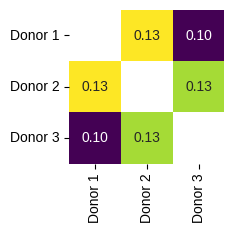

In [52]:
# - feature importance preservation across donors  -> only intersections 

def plot_feature_importance_correlation_variation_across_donors(feature_importance_all_reg1, ax):
    def lambda_func(df):
        return df['feature_importance'].values.flatten()

    # feature_importance
    df_pivot = feature_importance_all_reg1.groupby('donor_id').apply(lambda_func)
    df_pivot = pd.DataFrame(df_pivot.tolist(), index=df_pivot.index)

    # Calculate the Spearman correlation matrix
    corr_matrix = df_pivot.T.corr(method='spearman')

    np.fill_diagonal(corr_matrix.values, np.nan)
    # Plot heatmap on the appropriate subplot axis
    sns.heatmap(corr_matrix, annot=True, cmap="viridis", cbar=False, ax=ax, fmt='.2f')

    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis='y', rotation=0)
    ax.tick_params(axis='x', rotation=90)
    # for label in ax.get_xticklabels():
    #     label.set_ha('right')  # Set horizontal alignment to 'left'


    # plt.title('TF activation similarity (OPSCA)', fontsize=12, fontweight='bold', pad=15)
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
plot_feature_importance_correlation_variation_across_donors(feature_importance_all_reg1, ax)
# plt.tight_layout()

# fig.savefig(f"{RESULT_DIR}/figs/reg1_feature_importannce_donor_corr.png", dpi=300, transparent=True, bbox_inches='tight')


### Feature importance stability across models

In [53]:
df = feature_importance_all_reg1
df_stability_models_reg1 = df.groupby(['perturbation','model'])[['tf', 'feature_importance']].apply(lambda df: df.groupby('tf').apply(lambda row: (np.mean(row)+1E-6)/(np.std(row)+1E-6))).reset_index()
df_stability_models_reg1['contextual_tf_activity'] = 1/df_stability_models_reg1['feature_importance']

In [54]:
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind

p_values = {}
for model in df_stability_models_reg1.model.unique():
    baseline = df_stability_models_reg1[df_stability_models_reg1['model']=='GRaNIE']['contextual_tf_activity'].values

    values = df_stability_models_reg1[df_stability_models_reg1['model']==model]['contextual_tf_activity'].values
    stat, p_value = mannwhitneyu(values, baseline, alternative='two-sided')
    # stat, p_value = ttest_ind(values, baseline, alternative='two-sided')
    
    p_values[model] = (1 if (np.median(values)>np.median(baseline)) else -1)*p_value*3

/vol/tmp/users/jnourisa/ipykernel_3245699/1149211804.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['model'] = filtered_data['model'].astype(category_order_reg1)


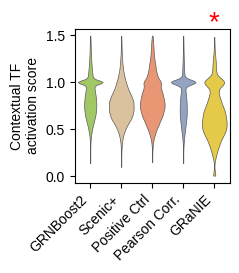

In [55]:

def plot_feature_importance_variation_across_perturbation(feature_importance_all_reg1, ax):

    top_95_quantile = df_stability_models_reg1['contextual_tf_activity'].quantile(0.99)
    filtered_data = df_stability_models_reg1[df_stability_models_reg1['contextual_tf_activity'] <= top_95_quantile]
    filtered_data['model'] = filtered_data['model'].astype(category_order_reg1)
    # sns.boxplot(df_stability_models_reg1, x='model', y='contextual_tf_activity', showfliers=False, boxprops={'edgecolor': 'none'}, ax=ax, palette=colors_methods_reg1)
    sns.violinplot(filtered_data, x='model', y='contextual_tf_activity', linewidth=0.5,  cut=0, inner=None, ax=ax, palette=palette_methods)

    
    ax.set_ylabel('Contextual TF\nactivation score')

    ax.set_xlabel("")
    # ax.legend(loc=(1, .5), title="Perturbation", frameon=False)

    # for side in ['right', 'top']:
    #     ax.spines[side].set_visible(False)

    # plt.title('TF activation stability across perturbation (OPSCA)', fontsize=12, fontweight='bold', pad=15)
    ax.tick_params(axis='x', rotation=45)
    for label in ax.get_xticklabels():
        label.set_ha('right')  # Set horizontal alignment to 'left'
    sigs = ['','','','','*']
    positions = [filtered_data['contextual_tf_activity'].max()]*5
    i = 0
    for ii, row_name in enumerate(range(df_stability_models_reg1['model'].nunique())):
        ax.text(
            i,  # x-coordinate
            positions[ii],  # Position above the highest point in the box
            sigs[ii],  # Format p-value in scientific notation
            ha='center',
            va='bottom',
            fontsize=20,
            color='red'
        )
        i+=1

    # plt.tight_layout()
fig, ax = plt.subplots(1, 1, figsize=(2, 2))

plot_feature_importance_variation_across_perturbation(feature_importance_all_reg1, ax)
fig.savefig(f"{RESULT_DIR}/figs/reg1_tf_activity_stability.png", dpi=300, transparent=True, bbox_inches='tight')


plt.show()

# Gene wise analysis: regression 2

In [5]:
dataset = 'replogle'
os.makedirs(f'{RESULT_DIR}/stability_analysis/gene_wise', exist_ok=True)
output_file = f'{RESULT_DIR}/stability_analysis/gene_wise/{dataset}_reg2.csv'

### Run the analysis

In [56]:
# %cd ..
!sbatch scripts/stability_analysis.sh {dataset} {output_file}

Submitted batch job 8928986


### Post run

In [22]:
from grn_benchmark.src.stability_analysis.gene_wise.script import get_par
par_reg2 = get_par(dataset)
scores_store_all_reg2 = pd.read_csv(output_file, index_col=0)
scores_store_all_reg2 = scores_store_all_reg2[scores_store_all_reg2['model'].isin(par_reg2['grn_models'])]
scores_store_all_reg2['feature_importance_mean2std_log'] = np.log1p(scores_store_all_reg2['feature_importance_mean2std'])
scores_store_all_reg2['contextual_tf_activity'] = 1/scores_store_all_reg2['feature_importance_mean2std']
scores_store_all_reg2.head()

,reg_type,donor_id,r2score,present,model,gene,n_regulator,n_present_regulators,feature_importance_mean2std,feature_importance_mean2std_log,contextual_tf_activity
0,ridge,donor_one,0.185842,True,scenic,NOC2L,3,2,13.191,2.652608,0.075809
1,ridge,donor_one,0.000000,True,scenic,KLHL17,2,1,2.574,1.273685,0.388500
2,ridge,donor_one,0.026112,True,scenic,ISG15,4,3,6.367,1.997011,0.157060
3,ridge,donor_one,0.045775,True,scenic,SDF4,3,2,7.932,2.189640,0.126072
4,ridge,donor_one,0.000000,True,scenic,B3GALT6,1,2,2.787,1.331574,0.358809


In [23]:
scores_store_all_reg2.model = scores_store_all_reg2.model.map(surrogate_names)
if 'donor_id' not in scores_store_all_reg2.columns:
    scores_store_all_reg2['donor_id'] = 'donor_0'
scores_store_all_reg2['donor_id'] = scores_store_all_reg2['donor_id'].map({'donor_0':'Donor 1', 'donor_1':'Donor 2', 'donor_2':'Donor 3'})
scores_store_present = scores_store_all_reg2[scores_store_all_reg2['present']]

### Feature stability scores

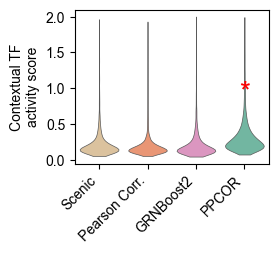

In [24]:
def plot_reg2_feature_stability_scores(scores_store_all_reg2, ax):
    from scipy.stats import mannwhitneyu
    scores_store_present = scores_store_all_reg2[scores_store_all_reg2['present']]
    df_common_pivot = scores_store_present.pivot(index=['model'], columns=['donor_id','gene'], values='feature_importance_mean2std').dropna(axis=1)
    common_genes = df_common_pivot.columns.get_level_values('gene').unique()
    df = df_common_pivot
    top_95_quantile = scores_store_present['contextual_tf_activity'].quantile(0.99)
    filtered_data = scores_store_present[scores_store_present['contextual_tf_activity'] <= top_95_quantile]
    sns.violinplot(filtered_data, x='model', y='contextual_tf_activity', linewidth=0.5,  cut=-1, inner=None, ax=ax, palette=palette_methods)
    ax.set_xlabel("")
    ax.set_ylabel("Contextual TF\nactivity score")
    ax.tick_params(axis='x', rotation=45)
    for label in ax.get_xticklabels():
        label.set_ha('right')  # Set horizontal alignment to 'left'
    sigs = ['','','','*','']
    positions = [.75]*4
    i = 0
    for ii, row_name in enumerate(range(scores_store_present['model'].nunique())):
        ax.text(
            i,  # x-coordinate
            positions[ii],  # Position above the highest point in the box
            sigs[ii],  # Format p-value in scientific notation
            ha='center',
            va='bottom',
            fontsize=20,
            color='red'
        )
        i+=1

fig, ax = plt.subplots(1, 1, figsize=(2.5, 2))
plot_reg2_feature_stability_scores(scores_store_all_reg2, ax)
# # plt.tight_layout()
# fig.savefig(f"{RESULT_DIR}/figs/reg2_feature_importance_stability.png", dpi=300, transparent=True, bbox_inches='tight')

# plt.show()


### Number of regulators vs r2 scores and tf activation stability

/vol/tmp/users/jnourisa/ipykernel_605441/2114650928.py:4: UserWarning: The palette list has more values (7) than needed (2), which may not be intended.
  sns.violinplot(filtered_data, x='present', y='contextual_tf_activity', linewidth=0.5,  cut=0, inner=None, ax=ax, palette=colors_blind)
/vol/tmp/users/jnourisa/ipykernel_605441/2114650928.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Random','GRN derived'])


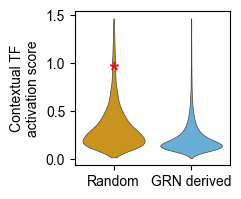

In [25]:
def plot_tf_activity_grn_derived(ax):
    top_95_quantile = scores_store_all_reg2['contextual_tf_activity'].quantile(.98)
    filtered_data = scores_store_all_reg2[scores_store_all_reg2['contextual_tf_activity'] <= top_95_quantile]
    sns.violinplot(filtered_data, x='present', y='contextual_tf_activity', linewidth=0.5,  cut=0, inner=None, ax=ax, palette=colors_blind)

    ax.set_ylabel('Contextual TF\nactivation score')

    ax.set_xlabel("")
    ax.set_xticklabels(['Random','GRN derived'])

    # plt.title('TF activation stability across perturbation (OPSCA)', fontsize=12, fontweight='bold', pad=15)
    ax.tick_params(axis='x', rotation=0)

    sigs = ['*','','','','']
    positions = [.75]*5
    i = 0
    for ii, row_name in enumerate(range(scores_store_all_reg2['model'].nunique())):
        ax.text(
            i,  # x-coordinate
            positions[ii],  # Position above the highest point in the box
            sigs[ii],  # Format p-value in scientific notation
            ha='center',
            va='bottom',
            fontsize=20,
            color='red'
        )
        i+=1
fig, ax = plt.subplots(1, 1, figsize=(2, 2), sharex=True)
plot_tf_activity_grn_derived(ax)
# plt.savefig(f"{RESULT_DIR}/figs/reg2_grnderived_stability.png", dpi=300, transparent=True, bbox_inches='tight')


/vol/tmp/users/jnourisa/ipykernel_605441/2114650928.py:4: UserWarning: The palette list has more values (7) than needed (2), which may not be intended.
  sns.violinplot(filtered_data, x='present', y='contextual_tf_activity', linewidth=0.5,  cut=0, inner=None, ax=ax, palette=colors_blind)
/vol/tmp/users/jnourisa/ipykernel_605441/2114650928.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Random','GRN derived'])


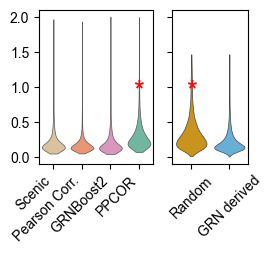

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(2.7, 2), width_ratios=[1.5, 1], sharey=True)
ax = axes[0]
plot_reg2_feature_stability_scores(scores_store_all_reg2, ax)
ax.set_ylabel('')
ax = axes[1]
plot_tf_activity_grn_derived(ax)
ax.tick_params(axis='x', rotation=45)
# plt.suptitle('R2', y=1.1)
ax.set_ylabel('')
plt.savefig(f"{RESULT_DIR}/figs/reg2_tf_activity.png", dpi=300, transparent=True, bbox_inches='tight')

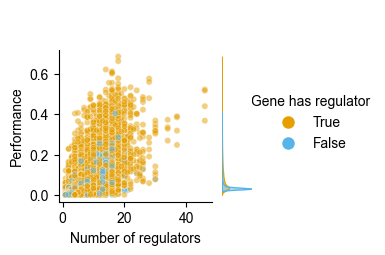

In [27]:
def plot_joint_reg2_tf_activity_vs_nregulators(scores_store_all_reg2, ax, top_plot=True):
    custom_jointplot(scores_store_all_reg2,x = 'n_regulator', 
             y = 'contextual_tf_activity', 
             hue= 'present', ax=ax, scatter_kws={'s':20})
    ax.legend(title="GRN-derived", frameon=False)
    ax.set_xlabel("Number of regulators")
    ax.set_ylabel("contextual_tf_activity")

def plot_joint_reg2_r2scores_vs_nregulators(scores_store_all_reg2, ax, top_plot=True):
    custom_jointplot(
        scores_store_all_reg2,
        x='n_regulator',
        y='r2score',
        hue='present',
        ax=ax,
        scatter_kws=dict(s=20, palette=palette_present),
        top_plot=top_plot
    )
    ax.set_xlabel("Number of regulators")
    ax.set_ylabel("Performance")


fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5), sharex=True)
palette_present = {True: colors_blind[0], False: colors_blind[1]}
plot_joint_reg2_r2scores_vs_nregulators(scores_store_all_reg2, ax, top_plot=False)
# legend matching the palette
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=palette_present[val],
           markersize=10, label=str(val))
    for val in [True, False]
]
ax.legend(handles=legend_elements, loc=(1.22, 0.3),
          frameon=False, title="Gene has regulator")
plt.savefig(f"{RESULT_DIR}/figs/reg2_nregulators_vs_r2scoes.png", dpi=300, transparent=True, bbox_inches='tight')

### Similary of scores across donors

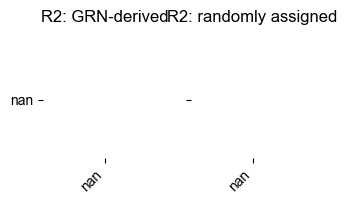

In [28]:
def plot_reg2_perfromance_similarity_donors(scores_store_all_reg2, axes):
    def plot_heatmap_local(corr_matrix, ax, vmin, vmax):
        np.fill_diagonal(corr_matrix.values, np.nan)  # Optional: mask diagonal
        sns.heatmap(
            corr_matrix, 
            annot=True, 
            cmap="viridis", 
            cbar=False, 
            ax=ax, 
            vmin=vmin, 
            vmax=vmax
        )
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.tick_params('y', rotation=0)
    scores_store_table = scores_store_all_reg2[scores_store_all_reg2['present']][['donor_id', 'r2score', 'model', 'gene']].pivot(
        index='donor_id', 
        values='r2score', 
        columns=['model', 'gene']
    )
    corr_matrix_grn = scores_store_table.T.corr(method='spearman')
    scores_store_table = scores_store_all_reg2[~scores_store_all_reg2['present']][['donor_id', 'r2score', 'model', 'gene']].pivot(
        index='donor_id', 
        values='r2score', 
        columns=['model', 'gene']
    )
    corr_matrix_random = scores_store_table.T.corr(method='spearman')
    vmin = min(corr_matrix_grn.min().min(), corr_matrix_random.min().min())
    vmax = max(corr_matrix_grn.max().max(), corr_matrix_random.max().max())
    plot_heatmap_local(corr_matrix_grn, axes[0], vmin, vmax)
    axes[0].set_title('R2: GRN-derived', pad=15)
    axes[0].tick_params(axis='x', rotation=45)
    for label in axes[0].get_xticklabels():
        label.set_ha('right')  # Set horizontal alignment to 'left'
    plot_heatmap_local(corr_matrix_random, axes[1], vmin, vmax)
    axes[1].set_title('R2: randomly assigned', pad=15)
    axes[1].tick_params(axis='x', rotation=45)
    for label in axes[1].get_xticklabels():
        label.set_ha('right')  # Set horizontal alignment to 'left'

    # Set global title and save figure
fig, axes = plt.subplots(1, 2, figsize=(3.5, 1.5), sharey=True)

plot_reg2_perfromance_similarity_donors(scores_store_all_reg2, axes)
# plt.suptitle('Performance correlation, regression 2', fontsize=12, fontweight='bold', y=1.01)
# plt.tight_layout()
# fig.savefig(
#     f"{RESULT_DIR}/figs/reg2_scores_similarity_donors.png", 
#     dpi=300, 
#     transparent=True, 
#     bbox_inches='tight'
# )

### Similariy of scores across models

/vol/tmp/users/jnourisa/ipykernel_605441/2606996912.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


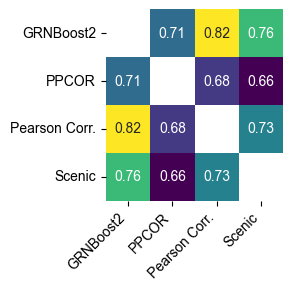

In [29]:
def plot_reg2_perfromance_similarity_models(scores_store_all_reg2, ax):
    scores_store_table = scores_store_all_reg2[['donor_id', 'r2score', 'model', 'gene']].pivot(
                index='model', 
                values='r2score', 
                columns=['donor_id', 'gene']
            )

    spearman_corr = scores_store_table.T.corr(method='spearman')
    np.fill_diagonal(spearman_corr.values, np.nan)
    sns.heatmap(spearman_corr, annot=True, cmap="viridis", cbar=False, ax=ax)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params('y', rotation=0)
    ax.tick_params(axis='x', rotation=45)
    for label in ax.get_xticklabels():
        label.set_ha('right')  # Set horizontal alignment to 'left'
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5), constrained_layout=True)
plot_reg2_perfromance_similarity_models(scores_store_all_reg2, ax)
plt.tight_layout()
fig.savefig(f"{RESULT_DIR}/figs/reg2_models_corr.png", dpi=300, transparent=True, bbox_inches='tight')

### Joint distribution of gene wise scores

/home/jnourisa/projs/ongoing/grn_benchmark/notebooks/../src/helper.py:234: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data, x=x, hue=hue, ax=top_ax, **kde_kws)
/home/jnourisa/projs/ongoing/grn_benchmark/notebooks/../src/helper.py:235: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data, y=y, hue=hue, ax=side_ax, **kde_kws)


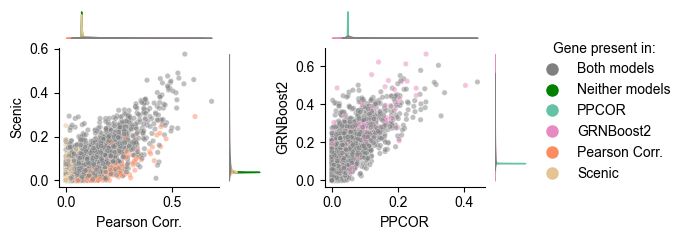

In [30]:
sys.path.append('../')
from src.helper import custom_jointplot
def plot_joint_gene_scores(method1, method2, ax):
    scores_store_table = scores_store_all_reg2.pivot_table(index='gene', columns='model', values='r2score', aggfunc='mean')
    present_table = scores_store_all_reg2.pivot_table(index='gene', columns='model', values='present', aggfunc='mean')
    present_table = present_table.astype(bool)
    scores_store_table['present'] = 'Neither models'
    scores_store_table.loc[present_table[method1], 'present'] = method1
    scores_store_table.loc[present_table[method2], 'present'] = method2
    scores_store_table.loc[present_table[method1]&present_table[method2], 'present'] = 'Both models'
    custom_jointplot(scores_store_table,x = method1, 
             y = method2, 
             hue= 'present', ax=ax,
             scatter_kws={'s':15, 
             'palette':[color_map[name] for name in scores_store_table['present'].unique()]},
            #  'palette':[color_map[name] for name in ['Positive Ctrl', 'Pearson Corr.', 'GRNBoost2', 'PPCOR', 'None', 'Both']]},
              alpha=.5)
    return scores_store_table
color_map = {'Neither models':'green', 'Both models':'grey', **palette_methods}
figsize = (7, 2.5)
fig, axes = plt.subplots(1, 2, figsize=figsize)
ax = axes[0]
aa = plot_joint_gene_scores('Pearson Corr.', 'Scenic+' if 'scenicplus' in par_reg2['grn_models'] else 'Scenic', ax=ax)
ax.get_legend().remove()
ax = axes[1]
aa = plot_joint_gene_scores('PPCOR', 'GRNBoost2', ax=ax)
ax.get_legend().remove()
legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[name], markersize=10, label=name)
        for name in ['Both models', 'Neither models', 'PPCOR', 'GRNBoost2', 'Pearson Corr.', 'Scenic+' if 'scenicplus' in par_reg2['grn_models'] else 'Scenic']
    ]
ax.legend(handles=legend_elements, loc=(1.3, 0), frameon=False, title='Gene present in:')
plt.tight_layout()
plt.savefig(f"{RESULT_DIR}/figs/reg2_joint_r2scores.png", dpi=300, transparent=True, bbox_inches='tight')
        

# Topological analysis

### Create peak gene edges

In [31]:
if False: # granie extended grn
    net = pd.read_csv(f'{task_grn_inference_dir}/resources/grn_models/peak_gene/granie_extended.csv')
    net = net[['peak', 'gene']].drop_duplicates().reset_index(drop=True)
    net.columns = ['peak','target']
    net.to_csv(f'{task_grn_inference_dir}/resources/grn_models/peak_gene/granie.csv')
if False:  # scenicplus extended grn
    net = pd.read_csv(f'{task_grn_inference_dir}/output/scenicplus/grn_extended.csv', index_col=0)
    net = net[['peak', 'target']].drop_duplicates().reset_index(drop=True)
    net.to_csv(f'{task_grn_inference_dir}/resources/grn_models/peak_gene/scenicplus.csv')
if False: # figr extended grn
    net = pd.read_csv(f'{task_grn_inference_dir}/output/figr/cisCorr.csv', index_col=0)
    net = net[['PeakRanges', 'Gene']].drop_duplicates().reset_index(drop=True)
    net.columns = ['peak','target']
    net.to_csv(f'{task_grn_inference_dir}/resources/grn_models/peak_gene/figr.csv')

In [32]:
# exp_objs_dict = {}

# for model in par_reg2['grn_models']:
#     par_reg2['grn_model'] = f"{par_reg2['grn_models_dir']}/{naming_convention(dataset, model)}"
#     # if not os.path.exists(par_reg2['grn_model']):
#     #     print(model, ' is skipped')
#     #     continue
#     prediction = ad.read_h5ad(par_reg2['grn_model'])
#     net = prediction.uns['prediction']

#     print(model, len(net))
#     obj = Exp_analysis(net)
#     obj.calculate_basic_stats()
#     exp_objs_dict[model] = obj


# interaction_info = create_interaction_info(exp_objs_dict)
# # fig = plot_interactions(interaction_info['target'], min_subset_size = 1, min_degree=1, color_map=None) 

In [33]:
order_names =[surrogate_names[name] for name in ['pearson_corr', 'grnboost', 'portia', 'ppcor']]

In [34]:
exp_objs_dict_dict = {}
for dataset in DATASETS:
# dataset = 'op' #'op', nakatake, adamson
    par_top_analysis = {
            'grn_models': ['positive_control', 'pearson_corr', 'ppcor', 'portia', 'grnboost', 'scenic', 'scglue', 'celloracle', 'figr', 'granie', 'scenicplus', 'scprint'],
            'shortlist': ['pearson_corr', 'ppcor', 'portia', 'grnboost'],
            'peak_gene_models': ['celloracle', 'scenicplus', 'figr', 'granie'],
            'peak_gene_dir': f'{task_grn_inference_dir}/resources/results/{dataset}/peak_gene/',
    }
    exp_objs_dict = {}
    nets_dict = {}
    for model in par_top_analysis['grn_models']:
        grn_file_name = retrieve_grn_path(dataset, model)
        if not os.path.exists(grn_file_name):
            print(dataset, model, ' is skipped')
            continue
        net = ad.read_h5ad(grn_file_name) 
        net = net.uns['prediction']
        net['weight'] = net['weight'].astype(float)
        net = net.drop_duplicates()
        nets_dict[model] = net
        if model in par_top_analysis['peak_gene_models']:
            peak_gene_net = pd.read_csv(f"{par_top_analysis['peak_gene_dir']}/{model}.csv")
        else:
            peak_gene_net = None
        print(model, len(net))
        obj = Exp_analysis(net, peak_gene_net)
        obj.calculate_basic_stats()
        obj.calculate_centrality()

        exp_objs_dict[model] = obj
    exp_objs_dict = {surrogate_names[key]:value for key,value in exp_objs_dict.items()}
    exp_objs_dict_dict[dataset] = exp_objs_dict

positive_control 50000
pearson_corr 50000
ppcor 50000
portia 50000
grnboost 50000
scenic 37325
scglue 4028


FileNotFoundError: [Errno 2] No such file or directory: '/home/jnourisa/projs/ongoing/task_grn_inference//resources/results/op/peak_gene//celloracle.csv'

## General stats

In [23]:
for i, dataset in enumerate(DATASETS):
    exp_objs_dict = exp_objs_dict_dict[dataset]
    # regulatory links
    links_n = {}
    source_n = {}
    target_n = {}
    nets = {}

    for name, obj in exp_objs_dict.items():
        net = obj.net
        if 'cell_type' in net.columns: # for cell specific grn models, take the mean
            n_grn = net.groupby('cell_type').size().mean()
        else:
            n_grn = len(net)

        links_n[name] = n_grn
        source_n[name] = obj.stats['n_source']
        target_n[name] = obj.stats['n_target']
    # Prepare data for plotting
    data = {
        'Model': [],
        'Count': [],
        'Type': []
    }

    # Populate the data dictionary for each metric
    for model in links_n.keys():
        data['Model'].append(model)
        data['Count'].append(links_n[model])
        data['Type'].append('Putative links')

    for model in source_n.keys():
        data['Model'].append(model)
        data['Count'].append(source_n[model])
        data['Type'].append('Putative TFs')

    for model in target_n.keys():
        data['Model'].append(model)
        data['Count'].append(target_n[model])
        data['Type'].append('Putative target genes')

    # Create a DataFrame from the data dictionary
    df = pd.DataFrame(data)
    df['Dataset'] = dataset
    if i == 0:
        topology_stats =df
    else:
        topology_stats = pd.concat([topology_stats, df]).reset_index(drop=True)
topology_stats.loc[topology_stats['Count']>50000, 'Count'] = 50000
topology_stats['Dataset'] = topology_stats['Dataset'].map(surrogate_names)


In [29]:
topology_stats

,Model,Count,Type,Dataset
0,Positive Ctrl,50000.0,Putative links,Replogle
1,Pearson Corr.,50000.0,Putative links,Replogle
2,scPRINT,50000.0,Putative links,Replogle
3,Positive Ctrl,476.0,Putative TFs,Replogle
4,Pearson Corr.,569.0,Putative TFs,Replogle
5,scPRINT,163.0,Putative TFs,Replogle
6,Positive Ctrl,3544.0,Putative target genes,Replogle
7,Pearson Corr.,4041.0,Putative target genes,Replogle
8,scPRINT,4851.0,Putative target genes,Replogle


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


dict_keys(['op', 'nakatake'])
Skipping op as no data is available.
Skipping nakatake as no data is available.


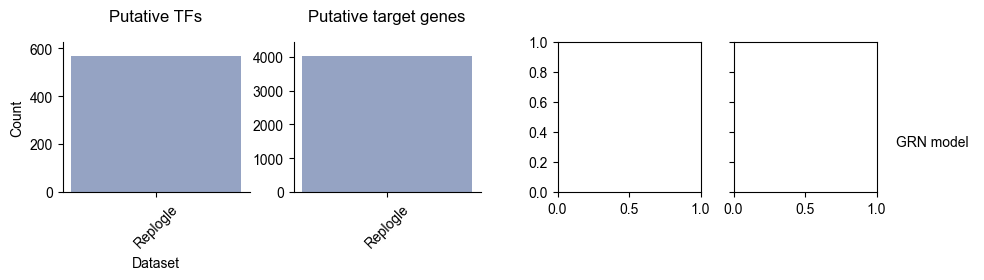

In [31]:
def plot_topology_short(axes):
    topology_stats_short = topology_stats[topology_stats['Model'].isin(order_names)]
    topology_stats_short = topology_stats_short[topology_stats_short['Type'].isin(['Putative TFs', 'Putative target genes'])]
    
    for i, type in enumerate(topology_stats_short['Type'].unique()):
        ax = axes[i]
        topology_stats_sub = topology_stats_short[topology_stats_short['Type']==type]
        sns.barplot(
            ax=ax,
            data=topology_stats_sub,
            hue='Model',
            hue_order=order_names,  # Specify the desired order of hue categories
            x='Dataset',
            y='Count',
            alpha=1,
            palette=palette_methods,
            # sharey=False,
            # height=2.2,  # Adjust plot size (smaller)
            # aspect=1.2    # Adjust aspect ratio
        )
        ax.get_legend().remove()
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.margins(x=.05, y=.1)
        
        ax.tick_params(axis='x', rotation=45)
        ax.set_title(type, pad=15)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        if i == 1:
            ax.set_xlabel('')
            ax.set_ylabel('')
        else:
            ax.set_xlabel('Dataset')

def plot_indegree_centrality(exp_objs_dict_dict, axes):
    print(exp_objs_dict_dict.keys())
    for i, dataset in enumerate(exp_objs_dict_dict.keys()):
        exp_objs_dict = exp_objs_dict_dict[dataset]
        if len(exp_objs_dict)==0:
            print(f"Skipping {dataset} as no data is available.")
            continue
        ax = axes[i]
        for name in ['pearson_corr', 'grnboost', 'portia', 'ppcor']:
            name = surrogate_names.get(name,name)
            obj = exp_objs_dict[name]
            obj.calculate_centrality()
            values = obj.tf_gene.in_deg.degree.values

            obj.plot_cumulative_density(values, title='', x_label='Number of regulators', ax=ax, alpha=.8, label=name, c=palette_methods[name], linestyle=linestyle_methods[name], linewidth=2)
            
            # ax.set_xlim([-5, 250])
            # ax.set_title('(a) In-degree centrality: TF-gene', pad=20)
        # plt.tight_layout()
        if i != 0:
            ax.set_ylabel('')
            ax.set_xlabel('')
        ax.set_title(surrogate_names[dataset], pad=15)
        ax.grid(False)
    # ax.legend(frameon=False, loc=(1.1, .5))

fig = plt.figure(figsize=(11, 2))
gs = fig.add_gridspec(1, 5)
ax1 = fig.add_subplot(gs[0, 0]) 
ax2 = fig.add_subplot(gs[0, 1]) 
ax3 = fig.add_subplot(gs[0, 2]) 
ax4 = fig.add_subplot(gs[0, 3]) 
plot_topology_short([ax1, ax2])
plot_indegree_centrality({key:value for key, value in exp_objs_dict_dict.items() if key in ['op', 'nakatake']}, [ax3, ax4])
ax4.set_yticklabels([])
ax4.legend(frameon=False, loc=(1.1, .2), title='GRN model')

ax1.set_position([0.01, 0.1, 0.17, 0.75])  
ax2.set_position([0.22, 0.1, 0.17, 0.75])  
ax3.set_position([0.46, 0.1, 0.13, 0.75])
ax4.set_position([0.62, 0.1, 0.13, 0.75]) 
plt.savefig(f"{RESULT_DIR}/figs/topology_stats.png", dpi=300, transparent=True, bbox_inches='tight')


In [72]:
additional_models = [model for model in topology_stats['Model'].unique() if model not in palette_methods.keys()]
palette_methods_all = {**{name:color for name, color in zip(additional_models, palette_celltype)}, **palette_methods}

In [73]:
single_modality = ['PPCOR', 'Positive Ctrl', 'Pearson Corr.', 'Portia', 'GRNBoost2', 'Scenic', 'scPRINT']

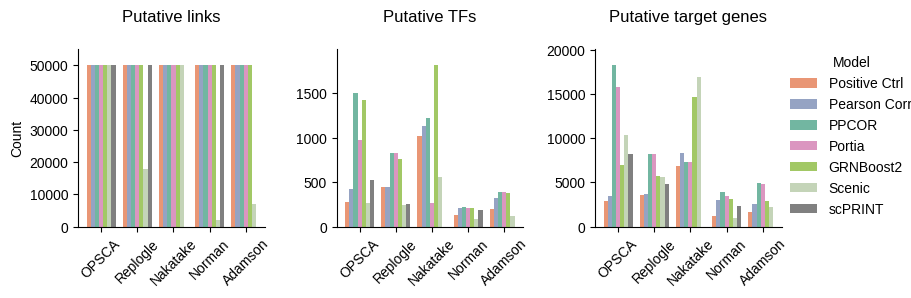

In [74]:
g = sns.catplot(
    data=topology_stats[topology_stats['Model'].isin(single_modality)],
    kind='bar',
    hue='Model',
    # hue_order=order_names,  # Specify the desired order of hue categories
    x='Dataset',
    y='Count',
    col='Type',
    # alpha=.5,
    palette=palette_methods_all,
    sharey=False,
    height=2.7,  # Adjust plot size (smaller)
    aspect=1    # Adjust aspect ratio
)

# Remove x and y-axis labels
g.set_axis_labels("")

# Update column titles
for ax, col_name in zip(g.axes.flat, topology_stats['Type'].unique()):
    ax.set_title(col_name, fontsize=12, pad=20)  # Replace 'Type' with only the name

# Rotate x-axis labels
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=45)

# Add top and right edges
for ax in g.axes.flat:
    # ax.spines['top'].set_visible(True)
    # ax.spines['right'].set_visible(True)
    ax.margins(x=.05, y=.1)
    # ax.

# Customize legend
g._legend.set_title("Model")
g._legend.set_bbox_to_anchor((.98, 0.6))  # Adjust legend position

# plt.tight_layout()
plt.savefig(f"{RESULT_DIR}/figs/topology_stats_1.png", dpi=300, transparent=True, bbox_inches='tight')


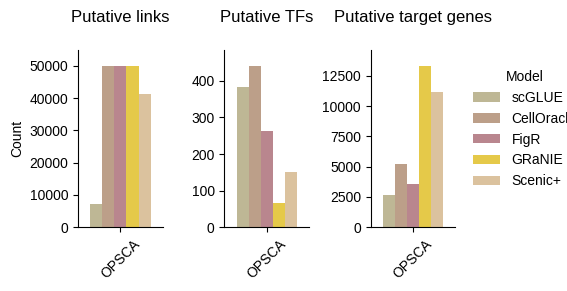

In [75]:
g = sns.catplot(
    data=topology_stats[~topology_stats['Model'].isin(single_modality)],
    kind='bar',
    hue='Model',
    # hue_order=order_names,  # Specify the desired order of hue categories
    x='Dataset',
    y='Count',
    col='Type',
    # alpha=.5,
    palette=palette_methods_all,
    sharey=False,
    height=2.7,  # Adjust plot size (smaller)
    aspect=.6    # Adjust aspect ratio
)

# Remove x and y-axis labels
g.set_axis_labels("")

# Update column titles
for ax, col_name in zip(g.axes.flat, topology_stats['Type'].unique()):
    ax.set_title(col_name, fontsize=12, pad=20)  # Replace 'Type' with only the name

# Rotate x-axis labels
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=45)

# Add top and right edges
for ax in g.axes.flat:
    # ax.spines['top'].set_visible(True)
    # ax.spines['right'].set_visible(True)
    ax.margins(x=.2, y=.1)
    # ax.

# Customize legend
g._legend.set_title("Model")
g._legend.set_bbox_to_anchor((.98, 0.6))  # Adjust legend position

# plt.tight_layout()
plt.savefig(f"{RESULT_DIR}/figs/topology_stats_2.png", dpi=300, transparent=True, bbox_inches='tight')


## Interactions 

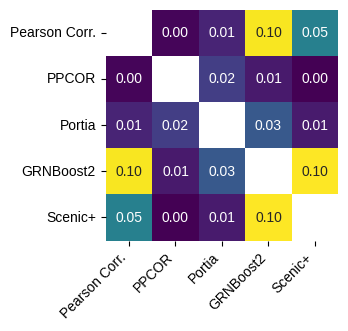

In [76]:
def plot_jaccard_similarity(dataset, ax):
    exp_objs_dict = exp_objs_dict_dict[dataset]
    exp_objs_dict = {key:value for key, value in exp_objs_dict.items() if key in ['Pearson Corr.', 'PPCOR', 'Portia', 'GRNBoost2', 'Scenic+']}
    nets = {}
    for name, obj in exp_objs_dict.items():
        nets[name] = obj.net
    _ = jaccard_similarity_net(nets, ax=ax)

    # ax.set_title(f'Jaccard similarity ({surrogate_names[dataset]})', pad=20, fontsize=12, fontweight='bold')
    ax.set_title(f'', pad=20, fontsize=12, fontweight='bold')
    

for i, dataset in enumerate(['op']):
    
    if dataset == 'op':
        figsize=(3, 3)
    else:
        figsize=(5, 4)
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    plot_jaccard_similarity(dataset, ax)
    # plt.savefig(f'{RESULT_DIR}/figs/jaccard_similarity_{dataset}.png', dpi=300, transparent=True, bbox_inches='tight')


# Combined plots

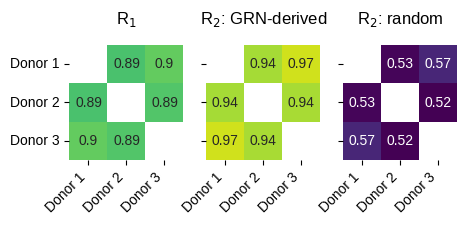

In [77]:
def plot_heatmap_local(corr_matrix, ax, vmin, vmax):
    np.fill_diagonal(corr_matrix.values, np.nan)  # Optional: mask diagonal
    sns.heatmap(
        corr_matrix, 
        annot=True, 
        cmap="viridis", 
        cbar=False, 
        ax=ax, 
        vmin=vmin, 
        vmax=vmax
    )
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params('y', rotation=0)
    ax.tick_params(axis='x', rotation=45)
    for label in ax.get_xticklabels():
        label.set_ha('right')  # Set horizontal alignment to 'left'


# - reg2 
scores_store_table_reg2 = scores_store_all_reg2[scores_store_all_reg2['present']][['donor_id', 'r2score', 'model', 'gene']].pivot(
    index='donor_id', 
    values='r2score', 
    columns=['model', 'gene']
)
corr_matrix_grn_reg2 = scores_store_table_reg2.T.corr(method='spearman')

# - reg1 
scores_store_table_reg1 = scores_store_all_reg1.pivot_table(
    index='donor_id', 
    values='r2score', 
    columns=[col for col in scores_store_all_reg1.columns if col not in ['donor_id', 'r2score']]
).fillna(0)

# Calculate the Spearman correlation matrix
corr_matrix_reg1 = scores_store_table_reg1.T.corr(method='spearman')
np.fill_diagonal(corr_matrix_reg1.values, np.nan)


# Determine the global vmin and vmax for consistent color scale
vmin = 0.6
vmax = 1


# plot_heatmap_local(corr_matrix_grn_reg2, ax, vmin, vmax)

fig, axes = plt.subplots(1, 3, figsize=(5, 1.5), sharey=True)

plot_heatmap_local(corr_matrix_reg1, axes[0], vmin, vmax)
axes[0].set_title(r'R$_{1}$', pad=15)

plot_reg2_perfromance_similarity_donors(scores_store_all_reg2, axes[1:])


# plot_heatmap_local(corr_matrix_grn_reg2, axes[1], vmin, vmax)
axes[1].set_title(r'R$_{2}$: GRN-derived', pad=15)
axes[2].set_title(r'R$_{2}$: random', pad=15)
plt.savefig(f'{RESULT_DIR}/figs/similaritys_donors.png', dpi=300, transparent=True, bbox_inches='tight')


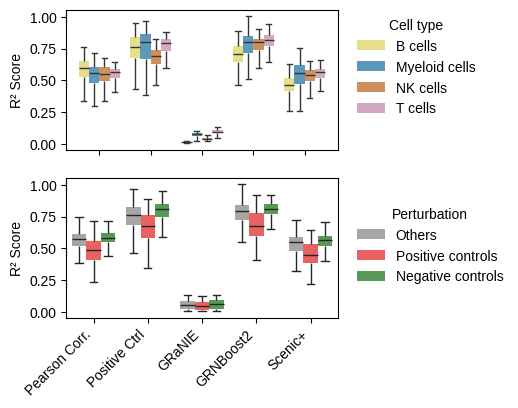

In [78]:
# - boxplot across models
fig, axes = plt.subplots(2, 1, figsize=(3.5, 4), sharey=True)

ax = axes[0]
plot_sample_wise_scores_segregated_by_celltypes(scores_store_all_reg1, ax)
ax.legend(loc=(1.05, .2), title="Cell type", frameon=False)
ax.set_xticklabels([])
ax = axes[1]
plot_sample_wise_scores_segregated_by_controls(scores_store_all_reg1, ax)
ax.legend(loc=(1.05, .2), title="Perturbation", frameon=False)

plt.savefig(f'{RESULT_DIR}/figs/boxplot_r2scores_tfactivation.png', dpi=300, transparent=True, bbox_inches='tight')


/vol/tmp/users/jnourisa/ipykernel_3245699/3636174929.py:15: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  sns.scatterplot(perturb_effect_all, x='STD fold change', y='Expression fold change', hue='perturbation_subset', alpha=.8, ax=ax, palette=sns.color_palette('Set2'))


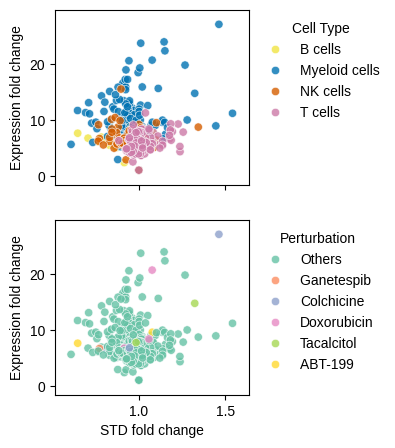

In [79]:
#- perturbation strength opsca
# - boxplot across models
fig, axes = plt.subplots(2, 1, figsize=(2.5, 5), sharex=True)

ax = axes[0]
plot_perturbation_strength_celltypes(perturb_effect_all, ax)
ax = axes[1]
plot_perturbation_strength_lowscored_samples(feature_importance_all_reg1, ax=ax)
ax.margins(x=0.1, y=0.1)

plt.savefig(f'{RESULT_DIR}/figs/opsca_perturbation_strength.png', dpi=300, transparent=True, bbox_inches='tight')


In [80]:
aaa

NameError: name 'aaa' is not defined

# CRE annoation

In [92]:
!ls {task_grn_inference_dir}/resources/grn_models/op/peak_gene

celloracle.csv	figr.csv  granie.csv  scenicplus.csv


In [100]:
exp_objs_multiomics_dict = {}

for model in ['celloracle','scenicplus', 'figr', 'granie']:
    grn_model = f'{task_grn_inference_dir}/resources/grn_models/{dataset}/{model}.h5ad'
    peak_gene_net = pd.read_csv(f'{task_grn_inference_dir}/resources/grn_models/op/peak_gene/{model}.csv')
    
    net = ad.read_h5ad(grn_model)
    net = net.uns['prediction']
    net['weight'] = net['weight'].astype(float)

    print(model, len(net))
    obj = Exp_analysis(net, peak_gene_net=peak_gene_net)
    obj.calculate_basic_stats()
    exp_objs_multiomics_dict[model] = obj

/home/jnourisa/miniconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jnourisa/miniconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jnourisa/miniconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jnourisa/miniconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


celloracle 50000
scenicplus 41288
figr 52962
granie 50000


/home/jnourisa/miniconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jnourisa/miniconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jnourisa/miniconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jnourisa/miniconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [101]:
annotation_df = pd.read_csv(f'{task_grn_inference_dir}/resources/grn_benchmark/prior/op/peak_annotation.csv')
annotation_df.head()
for key, obj in exp_objs_multiomics_dict.items():
    obj.annotate_peaks(annotation_df)

Not all peaks in the net is among the annotated ones. Finding the overlap


In [106]:
annotation_dict = {}
for name, obj in exp_objs_multiomics_dict.items():
    if obj.peak_annot is not None:
        annotation_dict[name] = obj.peak_annot
peak_annotation_df = pd.DataFrame.from_dict(annotation_dict, orient='index')
threshold = 1 # remove below this raction
peak_annotation_df = peak_annotation_df.loc[:, (peak_annotation_df>threshold).sum(axis=0)!=0]
peak_annotation_df

,Promoter,Intron,Distal Intergenic,Exon,3' UTR,Downstream (<=300)
celloracle,98.5,0.6,0.3,0.2,0.1,0.0
scenicplus,35.1,34.4,17.3,6.8,4.4,1.2
figr,30.4,37.8,18.0,6.7,4.7,1.5
granie,66.2,15.8,10.4,4.0,2.3,0.9


In [107]:
peak_annotation_df.index = peak_annotation_df.index.map(surrogate_names)

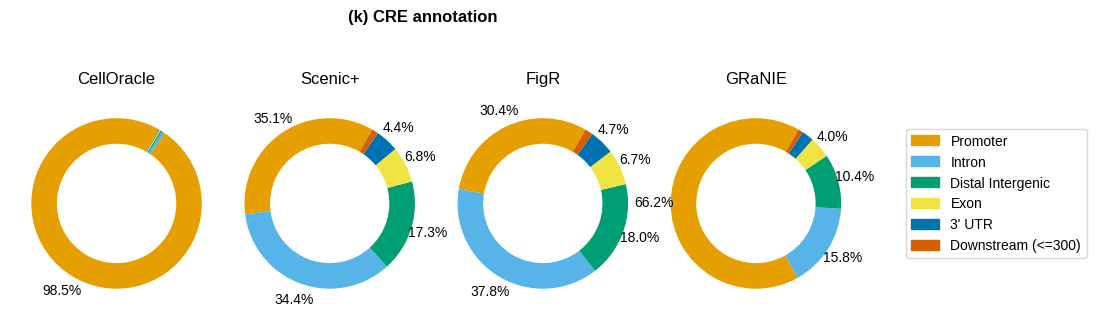

In [109]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np

# Create subplots with adjusted width ratios
fig, axes = plt.subplots(1, len(peak_annotation_df.index), figsize=(11, 4))
startangle = 60

# Iterate over pie charts
for i, (ax, idx) in enumerate(zip(axes, peak_annotation_df.index)):
    ax.set_title(idx, fontsize=12, pad=10)
    counts = peak_annotation_df.loc[idx]
    wedges, _ = ax.pie(counts, colors=colors_blind, wedgeprops=dict(width=0.3), startangle=startangle)

    for j, wedge in enumerate(wedges):
        if counts[j] == 0 or counts[j] < 4:  # Skip annotation for values less than 1%
            continue
        # Calculate angle and position for the annotation
        ang = (wedge.theta2 - wedge.theta1) / 2 + wedge.theta1
        x = np.cos(np.deg2rad(ang))
        y = np.sin(np.deg2rad(ang))
        ax.annotate(f'{counts[j]:.1f}%', xy=(x, y), xytext=(1.2*x, 1.2*y),
                    ha="center", va="center", fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.3", fc="none", ec="none"))

# Adjust spacing and add legend
plt.subplots_adjust(wspace=0)

# Create a single legend outside the pie charts
patches = [mpatches.Patch(color=color, label=name) for color, name in zip(colors_blind, peak_annotation_df.columns)]
fig.legend(handles=patches, loc='center right', bbox_to_anchor=(1.11, 0.52), fontsize=10)

fig.suptitle('(k) CRE annotation', fontsize=12, fontweight='bold')
# Save figure
fig.savefig(f'{RESULT_DIR}/figs/peak_annotation.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()